In [0]:
#pip install Pillow

In [0]:
#pip install scipy==1.1.0

In [3]:
import numpy as np
import pandas as pd 
import keras
from keras.layers import Input, Dense, Reshape, Flatten, Dropout,Concatenate
from keras.backend import random_normal,ones_like,zeros_like,mean
from keras.backend import get_session
from keras.layers import BatchNormalization, Activation, ZeroPadding2D
from keras.layers.advanced_activations import LeakyReLU
from keras.layers.convolutional import UpSampling2D, Conv2D
from keras.models import Sequential, Model
from keras.optimizers import Adam
from keras.initializers import TruncatedNormal
from PIL import Image
import warnings
import os
import time
from glob import glob
import datetime
import matplotlib.pyplot as plt
import seaborn as sns

Using TensorFlow backend.


In [0]:
import warnings
warnings.filterwarnings("ignore")
import random
from scipy import ndimage
from scipy import misc
from matplotlib.pyplot import imread
import numpy as np

In [0]:
# Hyperparameters
IMG_SIZE = 32
NOISE_SIZE = 100
LR_D = 0.00004
LR_G = 0.0004
BATCH_SIZE = 64
EPOCHS = 200 # For better results increase this value 
BETA1 = 0.5
WEIGHT_INIT_STDDEV = 0.02
EPSILON = 0.00005
SAMPLES_TO_SHOW = 10
img_rows = 32
img_cols = 32
CHANNELS = 3
img_shape = (img_rows, img_cols, CHANNELS)

In [0]:
CIFAR100_LABELS_LIST = [
    'apple', 'aquarium_fish', 'baby', 'bear', 'beaver', 'bed', 'bee', 'beetle', 
    'bicycle', 'bottle', 'bowl', 'boy', 'bridge', 'bus', 'butterfly', 'camel', 
    'can', 'castle', 'caterpillar', 'cattle', 'chair', 'chimpanzee', 'clock', 
    'cloud', 'cockroach', 'couch', 'crab', 'crocodile', 'cup', 'dinosaur', 
    'dolphin', 'elephant', 'flatfish', 'forest', 'fox', 'girl', 'hamster', 
    'house', 'kangaroo', 'keyboard', 'lamp', 'lawn_mower', 'leopard', 'lion',
    'lizard', 'lobster', 'man', 'maple_tree', 'motorcycle', 'mountain', 'mouse',
    'mushroom', 'oak_tree', 'orange', 'orchid', 'otter', 'palm_tree', 'pear',
    'pickup_truck', 'pine_tree', 'plain', 'plate', 'poppy', 'porcupine',
    'possum', 'rabbit', 'raccoon', 'ray', 'road', 'rocket', 'rose',
    'sea', 'seal', 'shark', 'shrew', 'skunk', 'skyscraper', 'snail', 'snake',
    'spider', 'squirrel', 'streetcar', 'sunflower', 'sweet_pepper', 'table',
    'tank', 'telephone', 'television', 'tiger', 'tractor', 'train', 'trout',
    'tulip', 'turtle', 'wardrobe', 'whale', 'willow_tree', 'wolf', 'woman',
    'worm'
]


In [7]:
from keras.datasets import cifar100
X_train = cifar100.load_data()
data = X_train[0]
images= data[0]
labels= data[1]

169009152/169001437 [==============================] - 2s 0us/step


In [8]:
print(images.shape)
print(labels.shape)

(50000, 32, 32, 3)
(50000, 1)


In [0]:
y=[]
x=[]
for i in range(len( labels)):
  y= labels[i]
  if y==0: #12 is for bridges
    x.append(images[i])

In [10]:
OUTPUT_DIR = ""
images=np.array(x)/(225)
images.shape

(500, 32, 32, 3)

In [0]:

def show_samples(sample_images, name, epoch):
    figure, axes = plt.subplots(1, len(sample_images), figsize = (IMG_SIZE, IMG_SIZE))
    figure.set_size_inches(15,15)
    for index, axis in enumerate(axes):
        image_array = sample_images[index]
        axis.imshow(image_array)
    plt.tight_layout()
    plt.show()
    plt.close()

Input: (500, 32, 32, 3)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


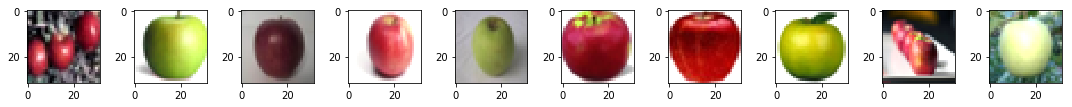

In [12]:
print ("Input: " + str(images.shape))
sample_images = random.sample(list(images), SAMPLES_TO_SHOW)
show_samples(sample_images, OUTPUT_DIR + "inputs", 0)

# **GANs** **starts**

In [0]:
def GeneratorFunction(noise_shape=(NOISE_SIZE,)):
    
    input_layer = Input(noise_shape)
    generator = Dense(1024*8*8, activation='relu')(input_layer)
    generator = Reshape((8, 8, 1024)) (generator) #8,8,1024
    generator = LeakyReLU(alpha=0.2) (generator)#8,8,1024
                        
    generator = keras.layers.Conv2DTranspose(filters=512, kernel_size=[5,5], padding="same",
                                             strides=[2,2], kernel_initializer=TruncatedNormal(stddev = WEIGHT_INIT_STDDEV))(generator)#16,16,512
    generator = BatchNormalization(momentum=0.8,epsilon = EPSILON) (generator)#16,16,512
    generator = keras.layers.LeakyReLU(alpha=0.2) (generator)#16,16,512
                        
    generator = keras.layers.Conv2DTranspose(filters=256, kernel_size=[5,5], padding="same", strides=[2,2],
                                               kernel_initializer=TruncatedNormal(stddev = WEIGHT_INIT_STDDEV))(generator) #32,32,256
    generator = BatchNormalization(momentum=0.8,epsilon = EPSILON,name="batch_trans_conv2") (generator)#32,32,256
    generator = keras.layers.LeakyReLU(alpha=0.2) (generator) #32,32,256
                        
    generator = keras.layers.Conv2DTranspose(filters=128, kernel_size=[5,5], padding="same", strides=[1,1],
                                               kernel_initializer=TruncatedNormal(stddev = WEIGHT_INIT_STDDEV)) (generator)#64,64,128
    generator = BatchNormalization(momentum=0.8,epsilon = EPSILON,name="batch_trans_conv3") (generator) #64,64,128
    generator = keras.layers.LeakyReLU(alpha=0.2)(generator)#64,64,128
    
    generator = keras.layers.Conv2DTranspose(filters=64, kernel_size=[5,5], padding="same", strides=[1,1],
                                               kernel_initializer=TruncatedNormal(stddev = WEIGHT_INIT_STDDEV)) (generator)#64,64,64
    generator = BatchNormalization(momentum=0.8,epsilon = EPSILON,name="batch_trans_conv4") (generator) #64,64,64
    generator = keras.layers.LeakyReLU(alpha=0.2) (generator) #64,64,64
    
    generator = keras.layers.Conv2DTranspose(filters=3, kernel_size=[5,5], padding="same", strides=[1,1],
                                               kernel_initializer=TruncatedNormal(stddev = WEIGHT_INIT_STDDEV)) (generator) #64,64,3
    out = Activation("tanh")(generator) #64,64,3
    
    model = Model(inputs=[input_layer], outputs=out)
    model.summary()
  
    return model

In [0]:
def discriminatorFunction(img_shape=(IMG_SIZE, IMG_SIZE, CHANNELS)):
    
    input_layer = Input(img_shape)
    discriminator = Conv2D(filters = 64, kernel_size=[5,5],strides=[2,2],kernel_initializer=TruncatedNormal(stddev = WEIGHT_INIT_STDDEV), 
                             padding="SAME",input_shape = img_shape)(input_layer)
    
    discriminator = BatchNormalization(momentum=0.8,epsilon = EPSILON)(discriminator)
    discriminator = LeakyReLU(alpha=0.2)(discriminator)

    discriminator = Conv2D(filters=128, kernel_size=[5,5], strides=[2,2], padding="same",
                              kernel_initializer=TruncatedNormal(stddev = WEIGHT_INIT_STDDEV))(discriminator)

    discriminator = BatchNormalization(momentum=0.8,epsilon = EPSILON)(discriminator)
    discriminator = LeakyReLU(alpha=0.2)(discriminator)

    discriminator = Conv2D(filters=256, kernel_size=[5,5], strides=[2,2], padding="same",
                             kernel_initializer=TruncatedNormal(stddev = WEIGHT_INIT_STDDEV))(discriminator)

    discriminator = BatchNormalization(momentum=0.8,epsilon = EPSILON)(discriminator)
    discriminator = LeakyReLU(alpha=0.2)(discriminator)

    discriminator = Conv2D(filters=512, kernel_size=[5,5], strides=[1,1], padding="same",
                             kernel_initializer=TruncatedNormal(stddev = WEIGHT_INIT_STDDEV))(discriminator)

    discriminator = BatchNormalization(momentum=0.8,epsilon = EPSILON)(discriminator)
    discriminator = LeakyReLU(alpha=0.2)(discriminator)

    discriminator = Conv2D(filters=1024, kernel_size=[5,5], strides=[2,2], padding="same",
                             kernel_initializer=TruncatedNormal(stddev = WEIGHT_INIT_STDDEV))(discriminator)
    
    discriminator = BatchNormalization(momentum=0.8,epsilon = EPSILON)(discriminator)
    discriminator = LeakyReLU(alpha=0.2)(discriminator)

    discriminator = Flatten()(discriminator)

    out = Dense(1, activation='sigmoid')(discriminator)

    model = Model(inputs=[input_layer], outputs=out)
    model.summary()
    
    return model

In [15]:
#print("Discriminator")
model_discriminator = discriminatorFunction(img_shape=(IMG_SIZE, IMG_SIZE, CHANNELS))
model_discriminator.compile(loss='binary_crossentropy',
                                    optimizer=Adam(lr=LR_D, beta_1=BETA1),
                                    metrics=['accuracy'])







Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 32, 32, 3)         0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 16, 16, 64)        4864      
_________________________________________________________________
batch_normalization_1 (Batch (None, 16, 16, 64)        256       
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 16, 16, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 8, 8, 128)         204928    
_________________________________________________________________
batch_normalization_2 (Batch (None, 8, 8, 128)         512       
_________________________________________________________________
leaky_re_lu_2 (LeakyReLU)    (None, 8, 8, 128)       

In [16]:
print("Generator")
model_generator = GeneratorFunction(noise_shape=(NOISE_SIZE,))

Generator
Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 100)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 65536)             6619136   
_________________________________________________________________
reshape_1 (Reshape)          (None, 8, 8, 1024)        0         
_________________________________________________________________
leaky_re_lu_6 (LeakyReLU)    (None, 8, 8, 1024)        0         
_________________________________________________________________
conv2d_transpose_1 (Conv2DTr (None, 16, 16, 512)       13107712  
_________________________________________________________________
batch_normalization_6 (Batch (None, 16, 16, 512)       2048      
_________________________________________________________________
leaky_re_lu_7 (LeakyReLU)    (None, 16, 16, 512) 

In [17]:
#build thwe Gan
z = Input(shape=(NOISE_SIZE,))
img = model_generator(z)
model_discriminator.trainable = False #discriminator is not trainable for GANs
real = model_discriminator(img)
gan = Model(z, real)
gan.compile(loss='binary_crossentropy', optimizer=Adam(lr=LR_G, beta_1=BETA1))
print("Model created based on Discriminator and Generator")
gan.summary()


Model created based on Discriminator and Generator
Model: "model_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         (None, 100)               0         
_________________________________________________________________
model_2 (Model)              (None, 32, 32, 3)         24036739  
_________________________________________________________________
model_1 (Model)              (None, 1)                 17426817  
Total params: 41,463,556
Trainable params: 24,034,819
Non-trainable params: 17,428,737
_________________________________________________________________


In [0]:
def summarize_epoch(d_losses, g_losses):
    fig, ax = plt.subplots()
    plt.plot(d_losses, label='Discriminator', alpha=0.6)
    plt.plot(g_losses, label='Generator', alpha=0.6)
    plt.title("Losses")
    plt.legend()
    plt.show()
    plt.close()

In [0]:
# Adversarial ground truths
valid = np.ones((BATCH_SIZE, 1))
fake = np.zeros((BATCH_SIZE, 1))

r, c = 4, 4
noise = np.random.normal(0, 1, (r*c, NOISE_SIZE))

In [20]:
#calculate steps per epoch
steps_per_epoch = len(images)//BATCH_SIZE
print("Training begins... Total epochs: {}, steps per epoch: {}".format(EPOCHS, steps_per_epoch))

Training begins... Total epochs: 200, steps per epoch: 7


In [0]:
steps_list = [x for x in range(steps_per_epoch)]

  0%|          | 0/200 [00:00<?, ?it/s]

Epoch: 1/200 | Step: 1/7 [D loss: 1.5167, acc.: 24.22%] [G loss: 0.8636]
Epoch: 1/200 | Step: 2/7 [D loss: 1.6307, acc.: 50.00%] [G loss: 1.2338]
Epoch: 1/200 | Step: 3/7 [D loss: 0.8332, acc.: 55.47%] [G loss: 2.9957]
Epoch: 1/200 | Step: 4/7 [D loss: 0.7257, acc.: 53.91%] [G loss: 2.3204]
Epoch: 1/200 | Step: 5/7 [D loss: 1.0903, acc.: 39.06%] [G loss: 3.3688]
Epoch: 1/200 | Step: 6/7 [D loss: 0.2647, acc.: 94.53%] [G loss: 3.8472]
Epoch: 1/200 | Step: 7/7 [D loss: 0.2556, acc.: 92.19%] [G loss: 3.3100]


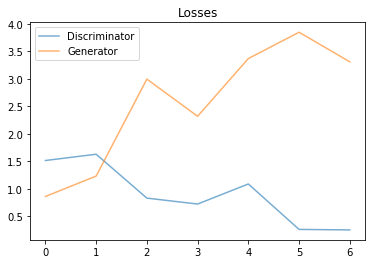

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

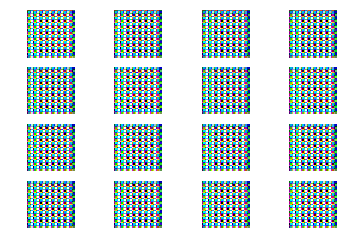

  0%|          | 1/200 [09:05<30:07:45, 545.05s/it]

Epoch: 2/200 | Step: 1/7 [D loss: 0.2980, acc.: 96.09%] [G loss: 6.3840]
Epoch: 2/200 | Step: 2/7 [D loss: 0.1083, acc.: 98.44%] [G loss: 3.7571]
Epoch: 2/200 | Step: 3/7 [D loss: 0.3622, acc.: 80.47%] [G loss: 6.6408]
Epoch: 2/200 | Step: 4/7 [D loss: 0.1069, acc.: 98.44%] [G loss: 3.1003]
Epoch: 2/200 | Step: 5/7 [D loss: 0.5657, acc.: 58.59%] [G loss: 5.7049]
Epoch: 2/200 | Step: 6/7 [D loss: 0.0938, acc.: 96.09%] [G loss: 2.7165]
Epoch: 2/200 | Step: 7/7 [D loss: 0.1590, acc.: 97.66%] [G loss: 1.3678]


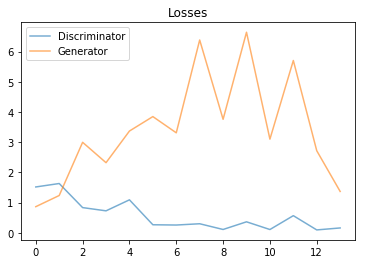

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

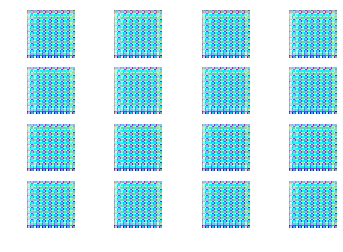

  1%|          | 2/200 [18:47<30:35:19, 556.16s/it]

Epoch: 3/200 | Step: 1/7 [D loss: 0.2031, acc.: 98.44%] [G loss: 2.6811]
Epoch: 3/200 | Step: 2/7 [D loss: 0.0977, acc.: 100.00%] [G loss: 4.3410]
Epoch: 3/200 | Step: 3/7 [D loss: 0.4706, acc.: 68.75%] [G loss: 11.0206]
Epoch: 3/200 | Step: 4/7 [D loss: 0.2503, acc.: 86.72%] [G loss: 8.9897]
Epoch: 3/200 | Step: 5/7 [D loss: 0.1884, acc.: 95.31%] [G loss: 3.5401]
Epoch: 3/200 | Step: 6/7 [D loss: 0.7522, acc.: 50.78%] [G loss: 7.0795]
Epoch: 3/200 | Step: 7/7 [D loss: 0.2831, acc.: 86.72%] [G loss: 6.1523]


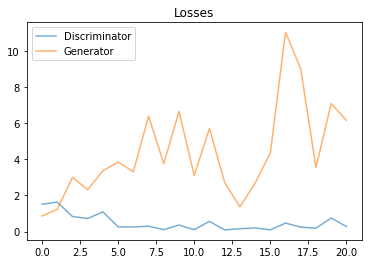

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

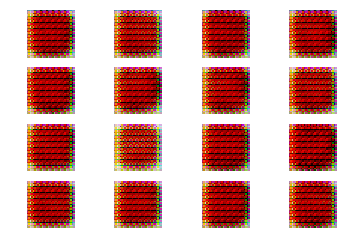

  2%|▏         | 3/200 [29:07<31:29:12, 575.40s/it]

Epoch: 4/200 | Step: 1/7 [D loss: 0.4602, acc.: 66.41%] [G loss: 2.7426]
Epoch: 4/200 | Step: 2/7 [D loss: 0.1619, acc.: 95.31%] [G loss: 1.5118]
Epoch: 4/200 | Step: 3/7 [D loss: 0.2538, acc.: 91.41%] [G loss: 0.3321]
Epoch: 4/200 | Step: 4/7 [D loss: 0.0676, acc.: 100.00%] [G loss: 0.1132]
Epoch: 4/200 | Step: 5/7 [D loss: 0.1014, acc.: 100.00%] [G loss: 0.0777]
Epoch: 4/200 | Step: 6/7 [D loss: 0.0886, acc.: 98.44%] [G loss: 0.1200]
Epoch: 4/200 | Step: 7/7 [D loss: 0.0732, acc.: 100.00%] [G loss: 0.2670]


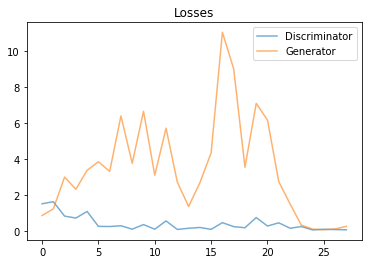

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

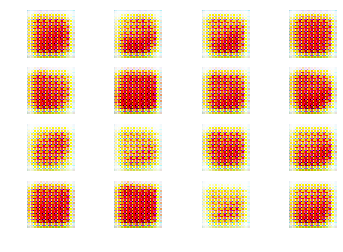

  2%|▏         | 4/200 [38:54<31:31:28, 579.02s/it]

Epoch: 5/200 | Step: 1/7 [D loss: 0.1264, acc.: 100.00%] [G loss: 1.4351]
Epoch: 5/200 | Step: 2/7 [D loss: 0.5964, acc.: 60.94%] [G loss: 8.6066]
Epoch: 5/200 | Step: 3/7 [D loss: 0.4337, acc.: 75.00%] [G loss: 5.3524]
Epoch: 5/200 | Step: 4/7 [D loss: 0.2371, acc.: 93.75%] [G loss: 3.8077]
Epoch: 5/200 | Step: 5/7 [D loss: 0.1330, acc.: 96.88%] [G loss: 3.3342]
Epoch: 5/200 | Step: 6/7 [D loss: 0.2010, acc.: 98.44%] [G loss: 4.2194]
Epoch: 5/200 | Step: 7/7 [D loss: 0.1316, acc.: 97.66%] [G loss: 3.5866]


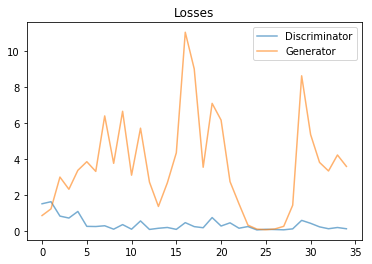

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

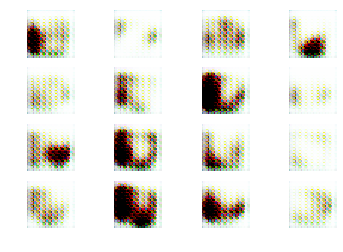

  2%|▎         | 5/200 [48:28<31:17:01, 577.55s/it]

Epoch: 6/200 | Step: 1/7 [D loss: 0.1957, acc.: 98.44%] [G loss: 3.6469]
Epoch: 6/200 | Step: 2/7 [D loss: 0.2778, acc.: 93.75%] [G loss: 3.5755]
Epoch: 6/200 | Step: 3/7 [D loss: 0.2092, acc.: 97.66%] [G loss: 3.1843]
Epoch: 6/200 | Step: 4/7 [D loss: 0.2923, acc.: 91.41%] [G loss: 3.4351]
Epoch: 6/200 | Step: 5/7 [D loss: 0.1929, acc.: 98.44%] [G loss: 3.5392]
Epoch: 6/200 | Step: 6/7 [D loss: 0.1713, acc.: 99.22%] [G loss: 3.1412]
Epoch: 6/200 | Step: 7/7 [D loss: 0.1818, acc.: 96.09%] [G loss: 3.3038]


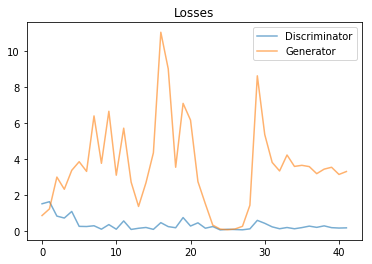

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

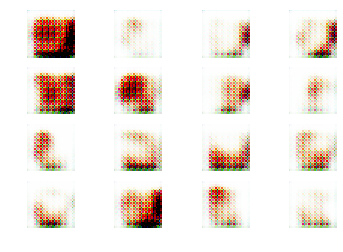

  3%|▎         | 6/200 [58:00<31:01:28, 575.71s/it]

Epoch: 7/200 | Step: 1/7 [D loss: 0.1150, acc.: 98.44%] [G loss: 3.4717]
Epoch: 7/200 | Step: 2/7 [D loss: 0.2317, acc.: 92.97%] [G loss: 3.2646]
Epoch: 7/200 | Step: 3/7 [D loss: 0.1941, acc.: 96.88%] [G loss: 3.4397]
Epoch: 7/200 | Step: 4/7 [D loss: 0.2142, acc.: 99.22%] [G loss: 3.2867]
Epoch: 7/200 | Step: 5/7 [D loss: 0.1053, acc.: 97.66%] [G loss: 2.8356]
Epoch: 7/200 | Step: 6/7 [D loss: 0.2037, acc.: 95.31%] [G loss: 2.4698]
Epoch: 7/200 | Step: 7/7 [D loss: 0.2155, acc.: 93.75%] [G loss: 1.8677]


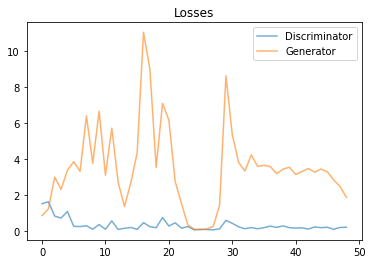

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

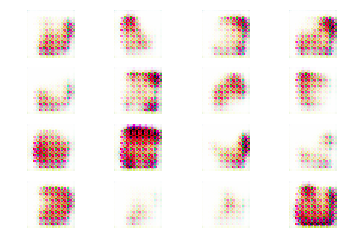

  4%|▎         | 7/200 [1:07:57<31:12:35, 582.15s/it]

Epoch: 8/200 | Step: 1/7 [D loss: 0.0830, acc.: 100.00%] [G loss: 1.1375]
Epoch: 8/200 | Step: 2/7 [D loss: 0.0724, acc.: 99.22%] [G loss: 0.2672]
Epoch: 8/200 | Step: 3/7 [D loss: 0.0550, acc.: 100.00%] [G loss: 0.1284]
Epoch: 8/200 | Step: 4/7 [D loss: 0.0747, acc.: 100.00%] [G loss: 0.1053]
Epoch: 8/200 | Step: 5/7 [D loss: 0.0382, acc.: 100.00%] [G loss: 0.0691]
Epoch: 8/200 | Step: 6/7 [D loss: 0.0942, acc.: 100.00%] [G loss: 0.1361]
Epoch: 8/200 | Step: 7/7 [D loss: 0.1360, acc.: 100.00%] [G loss: 0.4618]


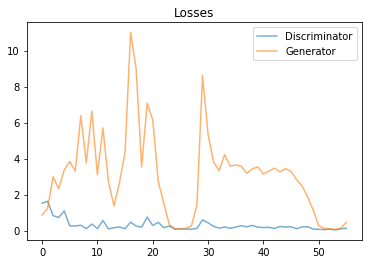

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

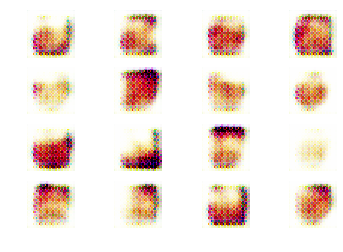

  4%|▍         | 8/200 [1:17:25<30:49:26, 577.95s/it]

Epoch: 9/200 | Step: 1/7 [D loss: 0.3284, acc.: 89.84%] [G loss: 1.5848]
Epoch: 9/200 | Step: 2/7 [D loss: 0.3022, acc.: 84.38%] [G loss: 0.5426]
Epoch: 9/200 | Step: 3/7 [D loss: 0.2900, acc.: 89.84%] [G loss: 1.3669]
Epoch: 9/200 | Step: 4/7 [D loss: 0.1629, acc.: 95.31%] [G loss: 1.0464]
Epoch: 9/200 | Step: 5/7 [D loss: 0.0269, acc.: 100.00%] [G loss: 0.1281]
Epoch: 9/200 | Step: 6/7 [D loss: 0.0190, acc.: 100.00%] [G loss: 0.0459]
Epoch: 9/200 | Step: 7/7 [D loss: 0.0544, acc.: 100.00%] [G loss: 0.0277]


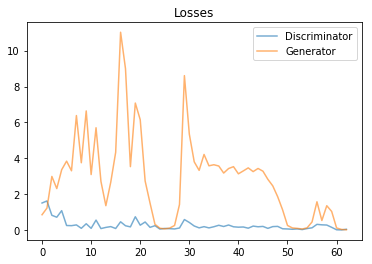

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

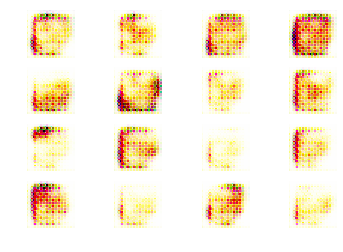

  4%|▍         | 9/200 [1:26:53<30:30:32, 575.04s/it]

Epoch: 10/200 | Step: 1/7 [D loss: 0.0713, acc.: 100.00%] [G loss: 0.0988]
Epoch: 10/200 | Step: 2/7 [D loss: 0.1614, acc.: 99.22%] [G loss: 1.0297]
Epoch: 10/200 | Step: 3/7 [D loss: 0.9851, acc.: 48.44%] [G loss: 8.7947]
Epoch: 10/200 | Step: 4/7 [D loss: 1.0902, acc.: 60.16%] [G loss: 4.2058]
Epoch: 10/200 | Step: 5/7 [D loss: 0.7291, acc.: 61.72%] [G loss: 6.2323]
Epoch: 10/200 | Step: 6/7 [D loss: 0.4111, acc.: 80.47%] [G loss: 4.5354]
Epoch: 10/200 | Step: 7/7 [D loss: 0.3367, acc.: 82.81%] [G loss: 1.2769]


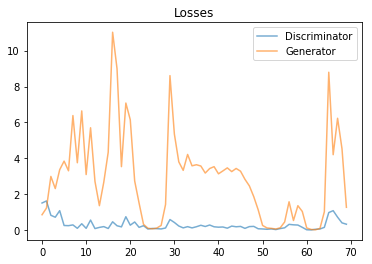

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

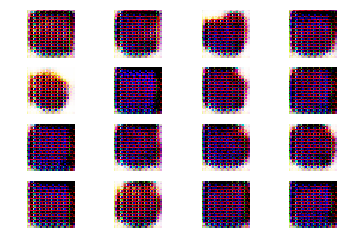

  5%|▌         | 10/200 [1:37:02<30:52:30, 585.00s/it]

Epoch: 11/200 | Step: 1/7 [D loss: 0.4175, acc.: 78.12%] [G loss: 2.4575]
Epoch: 11/200 | Step: 2/7 [D loss: 0.3144, acc.: 93.75%] [G loss: 3.4186]
Epoch: 11/200 | Step: 3/7 [D loss: 0.2424, acc.: 92.97%] [G loss: 3.3693]
Epoch: 11/200 | Step: 4/7 [D loss: 0.3729, acc.: 85.94%] [G loss: 2.6384]
Epoch: 11/200 | Step: 5/7 [D loss: 0.2852, acc.: 92.97%] [G loss: 3.5167]
Epoch: 11/200 | Step: 6/7 [D loss: 0.2702, acc.: 90.62%] [G loss: 3.1812]
Epoch: 11/200 | Step: 7/7 [D loss: 0.6963, acc.: 60.94%] [G loss: 3.2210]


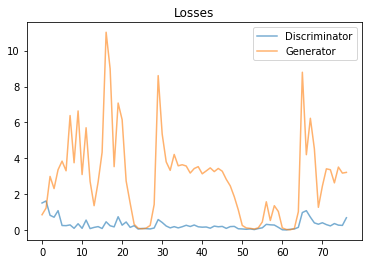

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

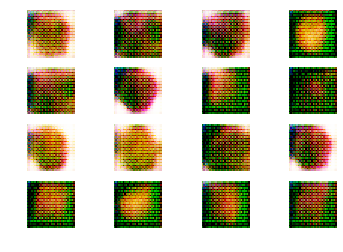

  6%|▌         | 11/200 [1:47:00<30:55:42, 589.11s/it]

Epoch: 12/200 | Step: 1/7 [D loss: 0.4986, acc.: 72.66%] [G loss: 0.5118]
Epoch: 12/200 | Step: 2/7 [D loss: 0.2984, acc.: 92.97%] [G loss: 0.2379]
Epoch: 12/200 | Step: 3/7 [D loss: 0.2138, acc.: 96.88%] [G loss: 0.2512]
Epoch: 12/200 | Step: 4/7 [D loss: 0.2973, acc.: 90.62%] [G loss: 1.0151]
Epoch: 12/200 | Step: 5/7 [D loss: 0.3286, acc.: 89.06%] [G loss: 0.7453]
Epoch: 12/200 | Step: 6/7 [D loss: 1.3436, acc.: 37.50%] [G loss: 5.8919]
Epoch: 12/200 | Step: 7/7 [D loss: 0.5802, acc.: 71.09%] [G loss: 2.7623]


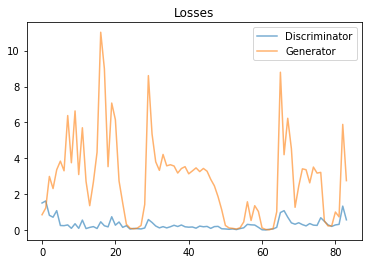

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

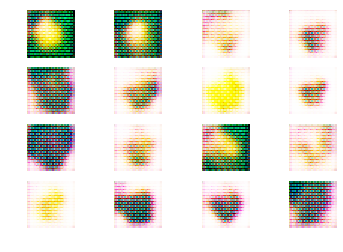

  6%|▌         | 12/200 [1:57:08<31:02:52, 594.54s/it]

Epoch: 13/200 | Step: 1/7 [D loss: 0.7814, acc.: 50.78%] [G loss: 4.6896]
Epoch: 13/200 | Step: 2/7 [D loss: 0.3870, acc.: 80.47%] [G loss: 3.7305]
Epoch: 13/200 | Step: 3/7 [D loss: 0.7482, acc.: 53.91%] [G loss: 3.5120]
Epoch: 13/200 | Step: 4/7 [D loss: 0.5309, acc.: 73.44%] [G loss: 4.5222]
Epoch: 13/200 | Step: 5/7 [D loss: 1.3429, acc.: 27.34%] [G loss: 3.2727]
Epoch: 13/200 | Step: 6/7 [D loss: 0.4558, acc.: 78.12%] [G loss: 2.8574]
Epoch: 13/200 | Step: 7/7 [D loss: 1.2407, acc.: 43.75%] [G loss: 5.0486]


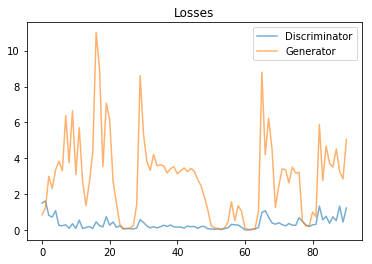

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

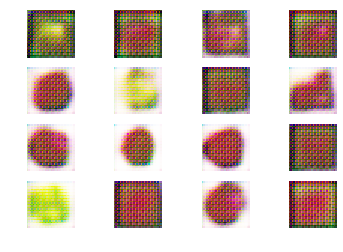

  6%|▋         | 13/200 [2:07:05<30:55:38, 595.39s/it]

Epoch: 14/200 | Step: 1/7 [D loss: 1.3444, acc.: 48.44%] [G loss: 2.1999]
Epoch: 14/200 | Step: 2/7 [D loss: 2.0566, acc.: 39.06%] [G loss: 3.1304]
Epoch: 14/200 | Step: 3/7 [D loss: 1.3904, acc.: 12.50%] [G loss: 3.3894]
Epoch: 14/200 | Step: 4/7 [D loss: 1.3392, acc.: 16.41%] [G loss: 2.9604]
Epoch: 14/200 | Step: 5/7 [D loss: 1.1616, acc.: 30.47%] [G loss: 2.9495]
Epoch: 14/200 | Step: 6/7 [D loss: 1.0280, acc.: 32.03%] [G loss: 2.1576]
Epoch: 14/200 | Step: 7/7 [D loss: 1.0340, acc.: 39.06%] [G loss: 1.3351]


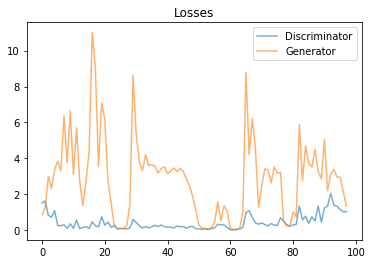

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

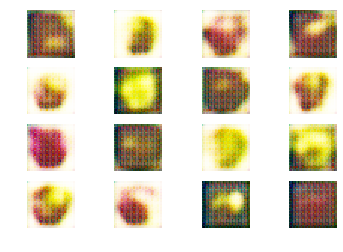

  7%|▋         | 14/200 [2:16:56<30:41:42, 594.10s/it]

Epoch: 15/200 | Step: 1/7 [D loss: 0.8729, acc.: 42.19%] [G loss: 1.5578]
Epoch: 15/200 | Step: 2/7 [D loss: 1.0788, acc.: 37.50%] [G loss: 1.6479]
Epoch: 15/200 | Step: 3/7 [D loss: 1.3254, acc.: 16.41%] [G loss: 2.6787]
Epoch: 15/200 | Step: 4/7 [D loss: 1.1857, acc.: 31.25%] [G loss: 2.3593]
Epoch: 15/200 | Step: 5/7 [D loss: 0.9573, acc.: 35.94%] [G loss: 2.0939]
Epoch: 15/200 | Step: 6/7 [D loss: 1.1357, acc.: 32.81%] [G loss: 1.7458]
Epoch: 15/200 | Step: 7/7 [D loss: 1.0537, acc.: 34.38%] [G loss: 1.8365]


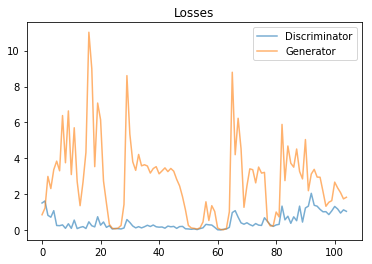

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

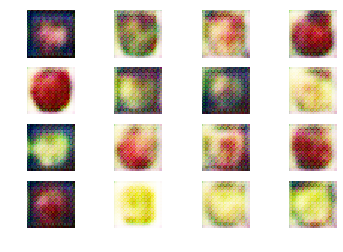

  8%|▊         | 15/200 [2:27:08<30:48:06, 599.39s/it]

Epoch: 16/200 | Step: 1/7 [D loss: 0.4880, acc.: 80.47%] [G loss: 1.1916]
Epoch: 16/200 | Step: 2/7 [D loss: 0.8869, acc.: 43.75%] [G loss: 1.3011]
Epoch: 16/200 | Step: 3/7 [D loss: 0.8534, acc.: 38.28%] [G loss: 1.4570]
Epoch: 16/200 | Step: 4/7 [D loss: 0.6887, acc.: 57.81%] [G loss: 1.4031]
Epoch: 16/200 | Step: 5/7 [D loss: 1.1583, acc.: 25.00%] [G loss: 1.6504]
Epoch: 16/200 | Step: 6/7 [D loss: 1.0118, acc.: 29.69%] [G loss: 1.7871]
Epoch: 16/200 | Step: 7/7 [D loss: 0.9399, acc.: 32.81%] [G loss: 1.6358]


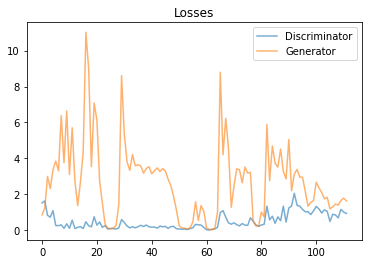

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

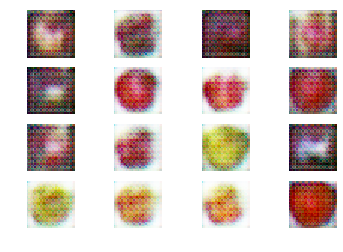

  8%|▊         | 16/200 [2:37:18<30:48:24, 602.74s/it]

Epoch: 17/200 | Step: 1/7 [D loss: 0.9899, acc.: 33.59%] [G loss: 1.4678]
Epoch: 17/200 | Step: 2/7 [D loss: 0.8737, acc.: 38.28%] [G loss: 1.6627]
Epoch: 17/200 | Step: 3/7 [D loss: 0.7530, acc.: 53.12%] [G loss: 1.6741]
Epoch: 17/200 | Step: 4/7 [D loss: 1.1136, acc.: 20.31%] [G loss: 1.8285]
Epoch: 17/200 | Step: 5/7 [D loss: 1.1738, acc.: 26.56%] [G loss: 1.7170]
Epoch: 17/200 | Step: 6/7 [D loss: 0.7672, acc.: 46.88%] [G loss: 1.6192]
Epoch: 17/200 | Step: 7/7 [D loss: 0.7126, acc.: 64.84%] [G loss: 2.3276]


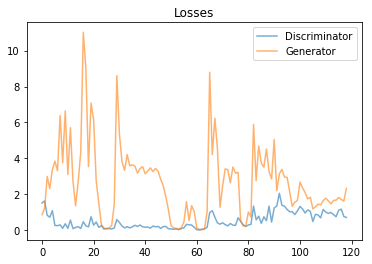

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

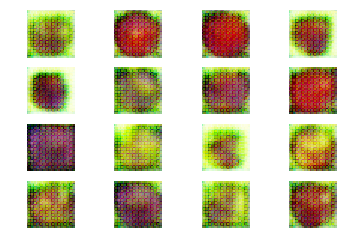

  8%|▊         | 17/200 [2:47:22<30:39:16, 603.04s/it]

Epoch: 18/200 | Step: 1/7 [D loss: 0.5992, acc.: 64.84%] [G loss: 1.8476]
Epoch: 18/200 | Step: 2/7 [D loss: 0.8556, acc.: 49.22%] [G loss: 1.2399]
Epoch: 18/200 | Step: 3/7 [D loss: 0.6412, acc.: 63.28%] [G loss: 0.8529]
Epoch: 18/200 | Step: 4/7 [D loss: 0.6659, acc.: 63.28%] [G loss: 1.0797]
Epoch: 18/200 | Step: 5/7 [D loss: 1.0276, acc.: 18.75%] [G loss: 1.6062]
Epoch: 18/200 | Step: 6/7 [D loss: 1.0908, acc.: 15.62%] [G loss: 1.7184]
Epoch: 18/200 | Step: 7/7 [D loss: 1.2002, acc.: 15.62%] [G loss: 1.5258]


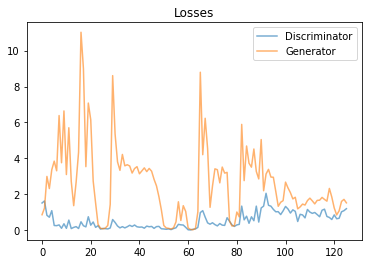

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

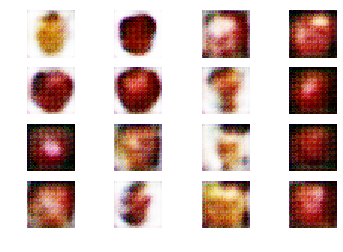

  9%|▉         | 18/200 [2:57:39<30:41:41, 607.15s/it]

Epoch: 19/200 | Step: 1/7 [D loss: 0.9682, acc.: 27.34%] [G loss: 1.7295]
Epoch: 19/200 | Step: 2/7 [D loss: 1.0419, acc.: 35.16%] [G loss: 1.5407]
Epoch: 19/200 | Step: 3/7 [D loss: 1.1157, acc.: 17.97%] [G loss: 1.6410]
Epoch: 19/200 | Step: 4/7 [D loss: 0.8174, acc.: 44.53%] [G loss: 1.6918]
Epoch: 19/200 | Step: 5/7 [D loss: 0.8457, acc.: 44.53%] [G loss: 1.5053]
Epoch: 19/200 | Step: 6/7 [D loss: 0.9071, acc.: 32.81%] [G loss: 1.4516]
Epoch: 19/200 | Step: 7/7 [D loss: 0.9800, acc.: 20.31%] [G loss: 1.5017]


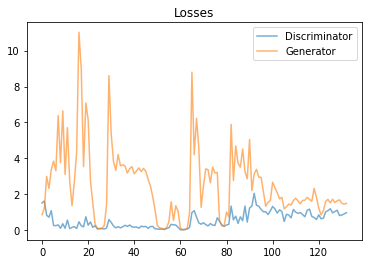

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

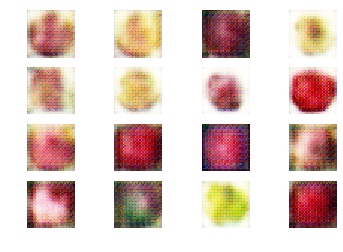

 10%|▉         | 19/200 [3:07:59<30:42:54, 610.91s/it]

Epoch: 20/200 | Step: 1/7 [D loss: 0.9063, acc.: 33.59%] [G loss: 1.5879]
Epoch: 20/200 | Step: 2/7 [D loss: 0.8334, acc.: 37.50%] [G loss: 1.6884]
Epoch: 20/200 | Step: 3/7 [D loss: 0.7328, acc.: 57.03%] [G loss: 1.4939]
Epoch: 20/200 | Step: 4/7 [D loss: 0.7460, acc.: 58.59%] [G loss: 1.3939]
Epoch: 20/200 | Step: 5/7 [D loss: 1.2052, acc.: 17.97%] [G loss: 1.2836]
Epoch: 20/200 | Step: 6/7 [D loss: 0.9546, acc.: 29.69%] [G loss: 1.3928]
Epoch: 20/200 | Step: 7/7 [D loss: 0.8562, acc.: 37.50%] [G loss: 1.4938]


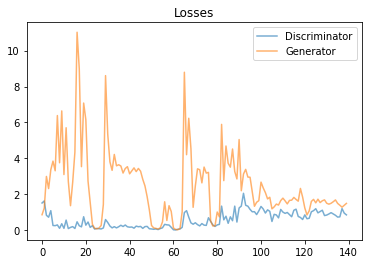

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

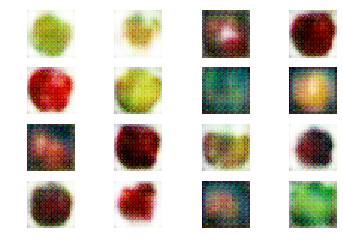

 10%|█         | 20/200 [3:18:14<30:36:59, 612.33s/it]

Epoch: 21/200 | Step: 1/7 [D loss: 0.9439, acc.: 30.47%] [G loss: 1.2742]
Epoch: 21/200 | Step: 2/7 [D loss: 1.0058, acc.: 24.22%] [G loss: 1.3222]
Epoch: 21/200 | Step: 3/7 [D loss: 0.8714, acc.: 32.03%] [G loss: 1.2871]
Epoch: 21/200 | Step: 4/7 [D loss: 0.9535, acc.: 25.00%] [G loss: 1.1970]
Epoch: 21/200 | Step: 5/7 [D loss: 0.8392, acc.: 32.03%] [G loss: 1.2329]
Epoch: 21/200 | Step: 6/7 [D loss: 0.8295, acc.: 39.06%] [G loss: 1.3189]
Epoch: 21/200 | Step: 7/7 [D loss: 0.9030, acc.: 27.34%] [G loss: 1.3375]


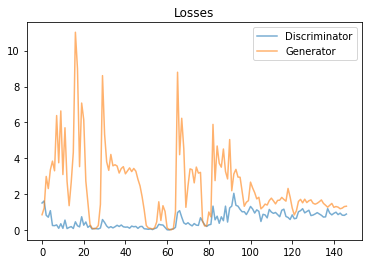

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

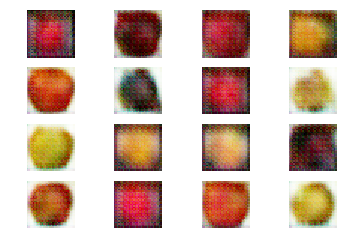

 10%|█         | 21/200 [3:28:24<30:24:17, 611.49s/it]

Epoch: 22/200 | Step: 1/7 [D loss: 0.8175, acc.: 36.72%] [G loss: 1.3549]
Epoch: 22/200 | Step: 2/7 [D loss: 0.9904, acc.: 28.91%] [G loss: 1.4567]
Epoch: 22/200 | Step: 3/7 [D loss: 0.8773, acc.: 39.06%] [G loss: 1.3132]
Epoch: 22/200 | Step: 4/7 [D loss: 0.8192, acc.: 38.28%] [G loss: 1.3859]
Epoch: 22/200 | Step: 5/7 [D loss: 0.9089, acc.: 25.78%] [G loss: 1.3254]
Epoch: 22/200 | Step: 6/7 [D loss: 0.7791, acc.: 42.19%] [G loss: 1.4484]
Epoch: 22/200 | Step: 7/7 [D loss: 0.8871, acc.: 25.78%] [G loss: 1.3350]


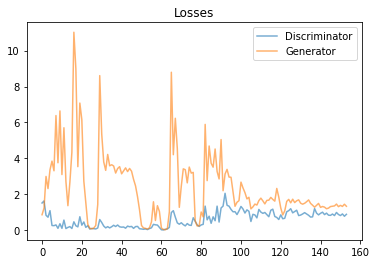

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

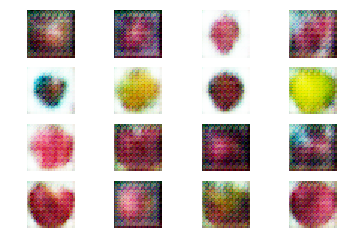

 11%|█         | 22/200 [3:38:01<29:43:34, 601.20s/it]

Epoch: 23/200 | Step: 1/7 [D loss: 0.7628, acc.: 43.75%] [G loss: 1.5037]
Epoch: 23/200 | Step: 2/7 [D loss: 0.8216, acc.: 35.16%] [G loss: 1.3033]
Epoch: 23/200 | Step: 3/7 [D loss: 0.7500, acc.: 39.84%] [G loss: 1.3638]
Epoch: 23/200 | Step: 4/7 [D loss: 0.7010, acc.: 50.00%] [G loss: 1.4363]
Epoch: 23/200 | Step: 5/7 [D loss: 0.6860, acc.: 54.69%] [G loss: 1.3291]
Epoch: 23/200 | Step: 6/7 [D loss: 0.8596, acc.: 30.47%] [G loss: 1.2975]
Epoch: 23/200 | Step: 7/7 [D loss: 0.7909, acc.: 43.75%] [G loss: 1.3186]


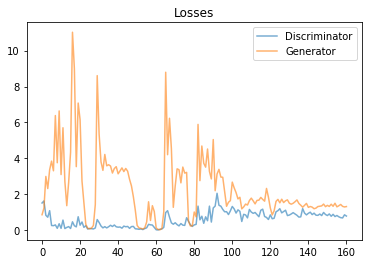

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

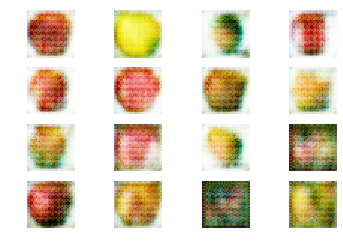

 12%|█▏        | 23/200 [3:48:07<29:38:02, 602.72s/it]

Epoch: 24/200 | Step: 1/7 [D loss: 0.9113, acc.: 28.12%] [G loss: 1.2549]
Epoch: 24/200 | Step: 2/7 [D loss: 0.8053, acc.: 35.94%] [G loss: 1.4866]
Epoch: 24/200 | Step: 3/7 [D loss: 0.7905, acc.: 38.28%] [G loss: 1.3683]
Epoch: 24/200 | Step: 4/7 [D loss: 0.7196, acc.: 46.09%] [G loss: 1.3790]
Epoch: 24/200 | Step: 5/7 [D loss: 0.8549, acc.: 32.81%] [G loss: 1.2620]
Epoch: 24/200 | Step: 6/7 [D loss: 0.8160, acc.: 34.38%] [G loss: 1.3892]
Epoch: 24/200 | Step: 7/7 [D loss: 0.7987, acc.: 42.97%] [G loss: 1.4019]


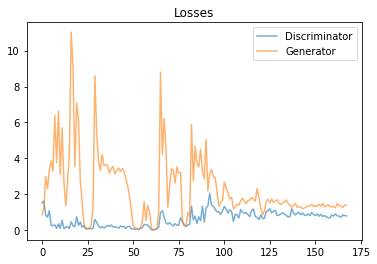

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

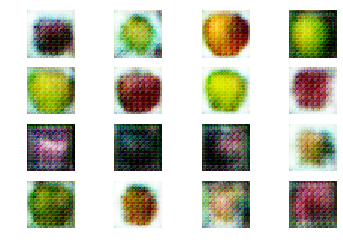

 12%|█▏        | 24/200 [3:57:25<28:48:44, 589.35s/it]

Epoch: 25/200 | Step: 1/7 [D loss: 0.7974, acc.: 42.97%] [G loss: 1.2942]
Epoch: 25/200 | Step: 2/7 [D loss: 0.7536, acc.: 46.88%] [G loss: 1.2784]
Epoch: 25/200 | Step: 3/7 [D loss: 0.7666, acc.: 47.66%] [G loss: 1.2404]
Epoch: 25/200 | Step: 4/7 [D loss: 0.8214, acc.: 42.97%] [G loss: 1.3093]
Epoch: 25/200 | Step: 5/7 [D loss: 0.8079, acc.: 32.03%] [G loss: 1.2788]
Epoch: 25/200 | Step: 6/7 [D loss: 0.8942, acc.: 27.34%] [G loss: 1.3327]
Epoch: 25/200 | Step: 7/7 [D loss: 0.8293, acc.: 33.59%] [G loss: 1.3412]


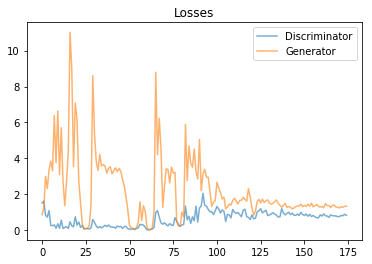

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

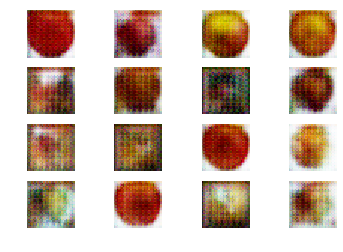

 12%|█▎        | 25/200 [4:06:26<27:56:43, 574.88s/it]

Epoch: 26/200 | Step: 1/7 [D loss: 0.7816, acc.: 43.75%] [G loss: 1.2995]
Epoch: 26/200 | Step: 2/7 [D loss: 0.7568, acc.: 41.41%] [G loss: 1.3003]
Epoch: 26/200 | Step: 3/7 [D loss: 0.7162, acc.: 46.09%] [G loss: 1.2686]
Epoch: 26/200 | Step: 4/7 [D loss: 0.7329, acc.: 46.88%] [G loss: 1.2109]
Epoch: 26/200 | Step: 5/7 [D loss: 0.7230, acc.: 46.09%] [G loss: 1.2954]
Epoch: 26/200 | Step: 6/7 [D loss: 0.7912, acc.: 39.06%] [G loss: 1.1962]
Epoch: 26/200 | Step: 7/7 [D loss: 0.8673, acc.: 27.34%] [G loss: 1.1189]


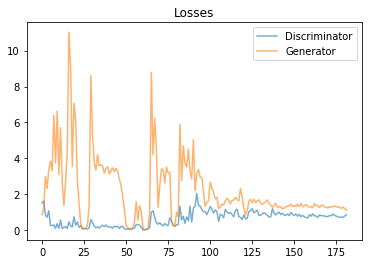

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

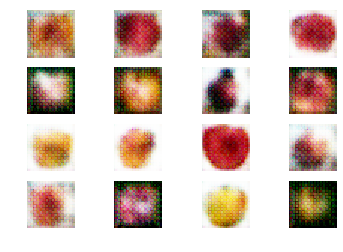

 13%|█▎        | 26/200 [4:15:55<27:41:48, 573.04s/it]

Epoch: 27/200 | Step: 1/7 [D loss: 0.8158, acc.: 36.72%] [G loss: 1.2151]
Epoch: 27/200 | Step: 2/7 [D loss: 0.8672, acc.: 30.47%] [G loss: 1.1910]
Epoch: 27/200 | Step: 3/7 [D loss: 0.7921, acc.: 42.97%] [G loss: 1.2463]
Epoch: 27/200 | Step: 4/7 [D loss: 0.8272, acc.: 32.03%] [G loss: 1.1554]
Epoch: 27/200 | Step: 5/7 [D loss: 0.7270, acc.: 46.09%] [G loss: 1.2925]
Epoch: 27/200 | Step: 6/7 [D loss: 0.7210, acc.: 49.22%] [G loss: 1.2828]
Epoch: 27/200 | Step: 7/7 [D loss: 0.7349, acc.: 46.09%] [G loss: 1.1820]


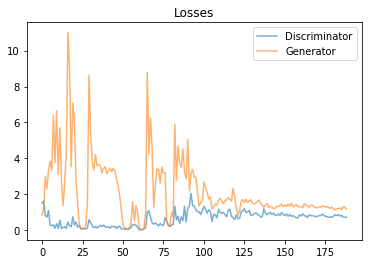

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

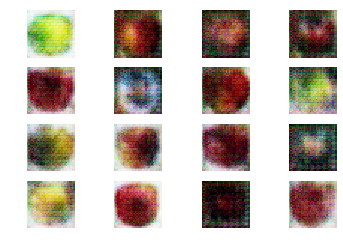

 14%|█▎        | 27/200 [4:25:40<27:42:34, 576.62s/it]

Epoch: 28/200 | Step: 1/7 [D loss: 0.7397, acc.: 48.44%] [G loss: 1.1749]
Epoch: 28/200 | Step: 2/7 [D loss: 0.7342, acc.: 47.66%] [G loss: 1.2127]
Epoch: 28/200 | Step: 3/7 [D loss: 0.7392, acc.: 50.00%] [G loss: 1.2809]
Epoch: 28/200 | Step: 4/7 [D loss: 0.7977, acc.: 38.28%] [G loss: 1.1925]
Epoch: 28/200 | Step: 5/7 [D loss: 0.7648, acc.: 43.75%] [G loss: 1.2892]
Epoch: 28/200 | Step: 6/7 [D loss: 0.6854, acc.: 57.81%] [G loss: 1.3454]
Epoch: 28/200 | Step: 7/7 [D loss: 0.7163, acc.: 48.44%] [G loss: 1.2351]


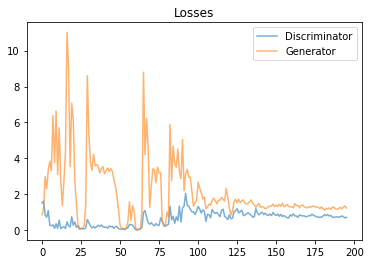

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

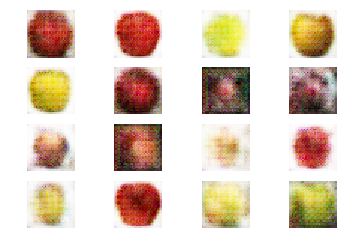

 14%|█▍        | 28/200 [4:35:21<27:36:19, 577.79s/it]

Epoch: 29/200 | Step: 1/7 [D loss: 0.7300, acc.: 43.75%] [G loss: 1.2147]
Epoch: 29/200 | Step: 2/7 [D loss: 0.7273, acc.: 46.09%] [G loss: 1.2114]
Epoch: 29/200 | Step: 3/7 [D loss: 0.7034, acc.: 50.00%] [G loss: 1.2506]
Epoch: 29/200 | Step: 4/7 [D loss: 0.7844, acc.: 34.38%] [G loss: 1.2162]
Epoch: 29/200 | Step: 5/7 [D loss: 0.7551, acc.: 42.19%] [G loss: 1.1930]
Epoch: 29/200 | Step: 6/7 [D loss: 0.7604, acc.: 44.53%] [G loss: 1.2281]
Epoch: 29/200 | Step: 7/7 [D loss: 0.7196, acc.: 50.78%] [G loss: 1.2350]


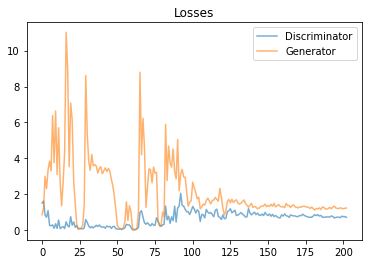

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

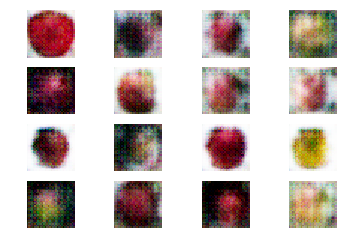

 14%|█▍        | 29/200 [4:45:40<28:02:29, 590.35s/it]

Epoch: 30/200 | Step: 1/7 [D loss: 0.7270, acc.: 49.22%] [G loss: 1.2115]
Epoch: 30/200 | Step: 2/7 [D loss: 0.6825, acc.: 57.81%] [G loss: 1.2377]
Epoch: 30/200 | Step: 3/7 [D loss: 0.7547, acc.: 35.16%] [G loss: 1.2239]
Epoch: 30/200 | Step: 4/7 [D loss: 0.7320, acc.: 50.78%] [G loss: 1.1954]
Epoch: 30/200 | Step: 5/7 [D loss: 0.7070, acc.: 51.56%] [G loss: 1.2779]
Epoch: 30/200 | Step: 6/7 [D loss: 0.7095, acc.: 46.09%] [G loss: 1.1785]
Epoch: 30/200 | Step: 7/7 [D loss: 0.7467, acc.: 47.66%] [G loss: 1.1762]


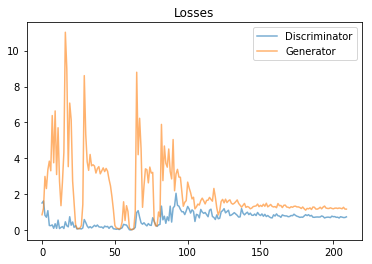

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

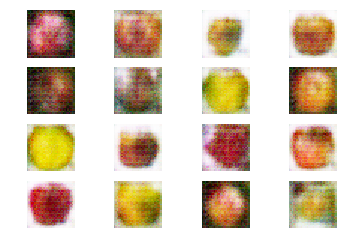

 15%|█▌        | 30/200 [4:55:55<28:13:10, 597.59s/it]

Epoch: 31/200 | Step: 1/7 [D loss: 0.6292, acc.: 63.28%] [G loss: 1.2574]
Epoch: 31/200 | Step: 2/7 [D loss: 0.7234, acc.: 53.12%] [G loss: 1.1728]
Epoch: 31/200 | Step: 3/7 [D loss: 0.7259, acc.: 52.34%] [G loss: 1.1945]
Epoch: 31/200 | Step: 4/7 [D loss: 0.7608, acc.: 46.09%] [G loss: 1.0996]
Epoch: 31/200 | Step: 5/7 [D loss: 0.6933, acc.: 54.69%] [G loss: 1.1933]
Epoch: 31/200 | Step: 6/7 [D loss: 0.7202, acc.: 50.78%] [G loss: 1.2096]
Epoch: 31/200 | Step: 7/7 [D loss: 0.6851, acc.: 57.81%] [G loss: 1.3658]


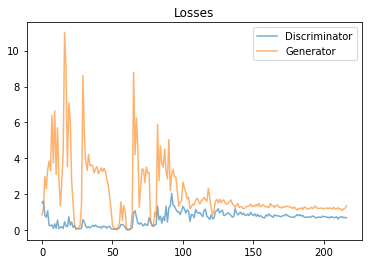

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

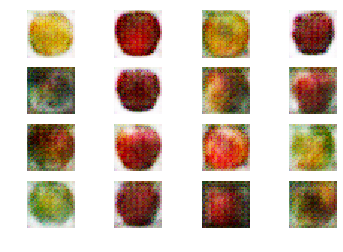

 16%|█▌        | 31/200 [5:06:13<28:20:13, 603.63s/it]

Epoch: 32/200 | Step: 1/7 [D loss: 0.8129, acc.: 25.00%] [G loss: 1.1583]
Epoch: 32/200 | Step: 2/7 [D loss: 0.6628, acc.: 59.38%] [G loss: 1.2694]
Epoch: 32/200 | Step: 3/7 [D loss: 0.7119, acc.: 56.25%] [G loss: 1.2115]
Epoch: 32/200 | Step: 4/7 [D loss: 0.7109, acc.: 47.66%] [G loss: 1.2002]
Epoch: 32/200 | Step: 5/7 [D loss: 0.6371, acc.: 70.31%] [G loss: 1.2528]
Epoch: 32/200 | Step: 6/7 [D loss: 0.7427, acc.: 42.97%] [G loss: 1.1752]
Epoch: 32/200 | Step: 7/7 [D loss: 0.7023, acc.: 51.56%] [G loss: 1.1697]


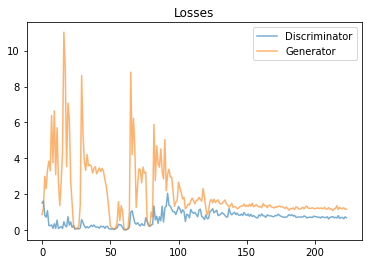

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

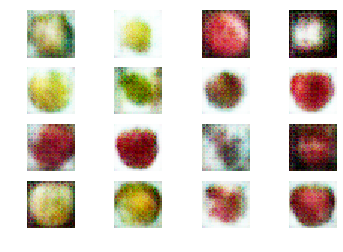

 16%|█▌        | 32/200 [5:16:25<28:17:55, 606.40s/it]

Epoch: 33/200 | Step: 1/7 [D loss: 0.6785, acc.: 57.81%] [G loss: 1.2152]
Epoch: 33/200 | Step: 2/7 [D loss: 0.6693, acc.: 57.81%] [G loss: 1.2033]
Epoch: 33/200 | Step: 3/7 [D loss: 0.7515, acc.: 44.53%] [G loss: 1.1284]
Epoch: 33/200 | Step: 4/7 [D loss: 0.7121, acc.: 53.91%] [G loss: 1.1814]
Epoch: 33/200 | Step: 5/7 [D loss: 0.7074, acc.: 51.56%] [G loss: 1.2420]
Epoch: 33/200 | Step: 6/7 [D loss: 0.7241, acc.: 48.44%] [G loss: 1.1672]
Epoch: 33/200 | Step: 7/7 [D loss: 0.6581, acc.: 62.50%] [G loss: 1.2718]


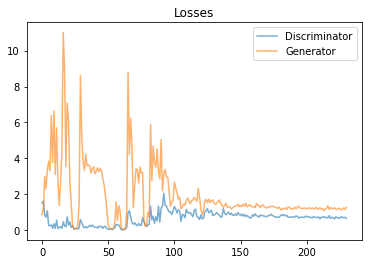

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

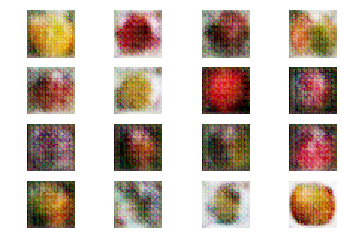

 16%|█▋        | 33/200 [5:26:44<28:17:59, 610.06s/it]

Epoch: 34/200 | Step: 1/7 [D loss: 0.7723, acc.: 42.19%] [G loss: 1.1306]
Epoch: 34/200 | Step: 2/7 [D loss: 0.6415, acc.: 67.19%] [G loss: 1.2588]
Epoch: 34/200 | Step: 3/7 [D loss: 0.6637, acc.: 64.06%] [G loss: 1.2149]
Epoch: 34/200 | Step: 4/7 [D loss: 0.6944, acc.: 51.56%] [G loss: 1.1872]
Epoch: 34/200 | Step: 5/7 [D loss: 0.7176, acc.: 42.19%] [G loss: 1.2155]
Epoch: 34/200 | Step: 6/7 [D loss: 0.6527, acc.: 60.16%] [G loss: 1.2356]
Epoch: 34/200 | Step: 7/7 [D loss: 0.7370, acc.: 46.09%] [G loss: 1.1761]


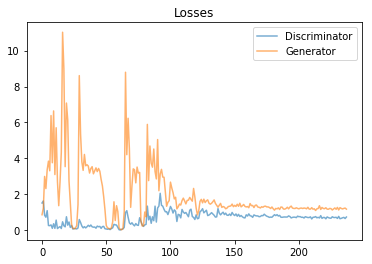

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

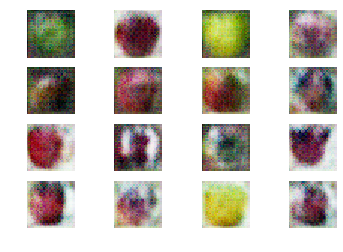

 17%|█▋        | 34/200 [5:36:57<28:10:12, 610.92s/it]

Epoch: 35/200 | Step: 1/7 [D loss: 0.6932, acc.: 58.59%] [G loss: 1.2040]
Epoch: 35/200 | Step: 2/7 [D loss: 0.6402, acc.: 63.28%] [G loss: 1.2414]
Epoch: 35/200 | Step: 3/7 [D loss: 0.7375, acc.: 48.44%] [G loss: 1.0909]
Epoch: 35/200 | Step: 4/7 [D loss: 0.7127, acc.: 45.31%] [G loss: 1.1875]
Epoch: 35/200 | Step: 5/7 [D loss: 0.7115, acc.: 52.34%] [G loss: 1.1980]
Epoch: 35/200 | Step: 6/7 [D loss: 0.7191, acc.: 48.44%] [G loss: 1.1845]
Epoch: 35/200 | Step: 7/7 [D loss: 0.5830, acc.: 78.91%] [G loss: 1.3194]


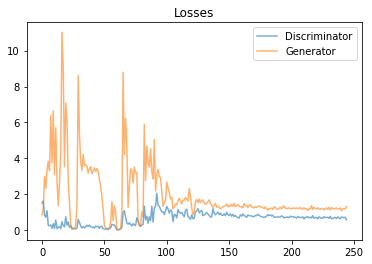

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

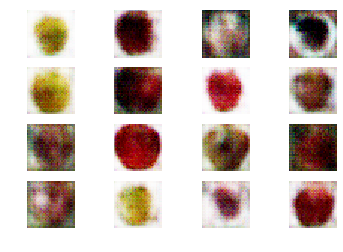

 18%|█▊        | 35/200 [5:46:59<27:52:50, 608.30s/it]

Epoch: 36/200 | Step: 1/7 [D loss: 0.7463, acc.: 39.06%] [G loss: 1.1797]
Epoch: 36/200 | Step: 2/7 [D loss: 0.6578, acc.: 60.94%] [G loss: 1.2695]
Epoch: 36/200 | Step: 3/7 [D loss: 0.6073, acc.: 67.97%] [G loss: 1.3544]
Epoch: 36/200 | Step: 4/7 [D loss: 0.6901, acc.: 54.69%] [G loss: 1.2387]
Epoch: 36/200 | Step: 5/7 [D loss: 0.6983, acc.: 50.78%] [G loss: 1.1554]
Epoch: 36/200 | Step: 6/7 [D loss: 0.6152, acc.: 73.44%] [G loss: 1.2674]
Epoch: 36/200 | Step: 7/7 [D loss: 0.6949, acc.: 54.69%] [G loss: 1.1739]


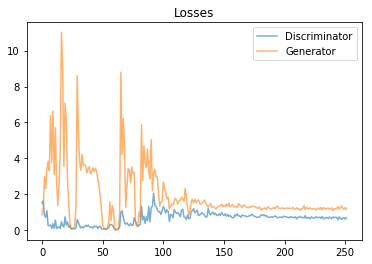

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

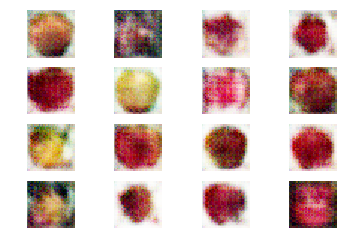

 18%|█▊        | 36/200 [5:57:14<27:48:09, 610.30s/it]

Epoch: 37/200 | Step: 1/7 [D loss: 0.6154, acc.: 67.97%] [G loss: 1.2679]
Epoch: 37/200 | Step: 2/7 [D loss: 0.7456, acc.: 47.66%] [G loss: 1.1878]
Epoch: 37/200 | Step: 3/7 [D loss: 0.7165, acc.: 46.88%] [G loss: 1.1885]
Epoch: 37/200 | Step: 4/7 [D loss: 0.6742, acc.: 61.72%] [G loss: 1.2180]
Epoch: 37/200 | Step: 5/7 [D loss: 0.7309, acc.: 48.44%] [G loss: 1.2022]
Epoch: 37/200 | Step: 6/7 [D loss: 0.6501, acc.: 63.28%] [G loss: 1.2104]
Epoch: 37/200 | Step: 7/7 [D loss: 0.6391, acc.: 66.41%] [G loss: 1.2133]


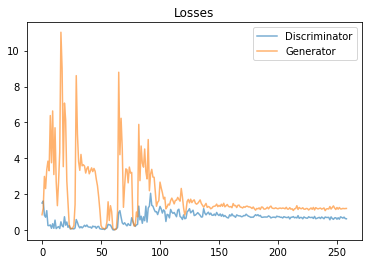

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

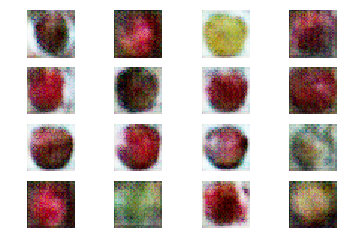

 18%|█▊        | 37/200 [6:07:33<27:45:06, 612.92s/it]

Epoch: 38/200 | Step: 1/7 [D loss: 0.7199, acc.: 49.22%] [G loss: 1.1507]
Epoch: 38/200 | Step: 2/7 [D loss: 0.6803, acc.: 58.59%] [G loss: 1.1891]
Epoch: 38/200 | Step: 3/7 [D loss: 0.6743, acc.: 59.38%] [G loss: 1.1940]
Epoch: 38/200 | Step: 4/7 [D loss: 0.6778, acc.: 54.69%] [G loss: 1.2106]
Epoch: 38/200 | Step: 5/7 [D loss: 0.6488, acc.: 64.84%] [G loss: 1.2227]
Epoch: 38/200 | Step: 6/7 [D loss: 0.6595, acc.: 64.06%] [G loss: 1.2727]
Epoch: 38/200 | Step: 7/7 [D loss: 0.6811, acc.: 60.16%] [G loss: 1.2149]


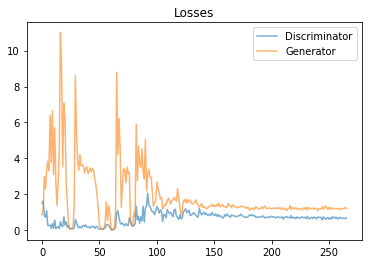

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

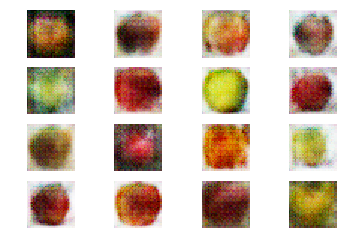

 19%|█▉        | 38/200 [6:17:47<27:35:59, 613.33s/it]

Epoch: 39/200 | Step: 1/7 [D loss: 0.7698, acc.: 35.94%] [G loss: 1.1192]
Epoch: 39/200 | Step: 2/7 [D loss: 0.6461, acc.: 66.41%] [G loss: 1.2451]
Epoch: 39/200 | Step: 3/7 [D loss: 0.7140, acc.: 50.78%] [G loss: 1.1840]
Epoch: 39/200 | Step: 4/7 [D loss: 0.6828, acc.: 53.12%] [G loss: 1.2396]
Epoch: 39/200 | Step: 5/7 [D loss: 0.6655, acc.: 60.94%] [G loss: 1.1620]
Epoch: 39/200 | Step: 6/7 [D loss: 0.6465, acc.: 62.50%] [G loss: 1.1817]
Epoch: 39/200 | Step: 7/7 [D loss: 0.6469, acc.: 65.62%] [G loss: 1.1999]


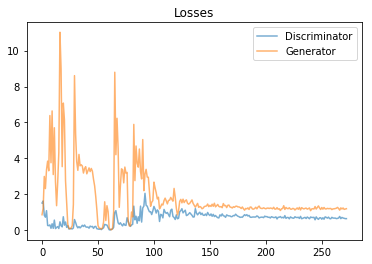

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

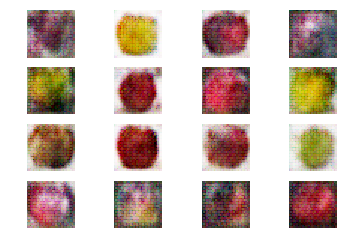

 20%|█▉        | 39/200 [6:28:03<27:27:12, 613.87s/it]

Epoch: 40/200 | Step: 1/7 [D loss: 0.6253, acc.: 68.75%] [G loss: 1.2884]
Epoch: 40/200 | Step: 2/7 [D loss: 0.6348, acc.: 68.75%] [G loss: 1.2366]
Epoch: 40/200 | Step: 3/7 [D loss: 0.6831, acc.: 54.69%] [G loss: 1.2114]
Epoch: 40/200 | Step: 4/7 [D loss: 0.6683, acc.: 64.06%] [G loss: 1.1774]
Epoch: 40/200 | Step: 5/7 [D loss: 0.6364, acc.: 66.41%] [G loss: 1.1996]
Epoch: 40/200 | Step: 6/7 [D loss: 0.6623, acc.: 58.59%] [G loss: 1.2392]
Epoch: 40/200 | Step: 7/7 [D loss: 0.6966, acc.: 55.47%] [G loss: 1.1847]


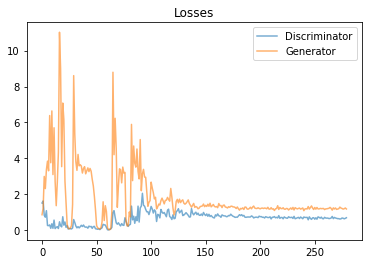

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

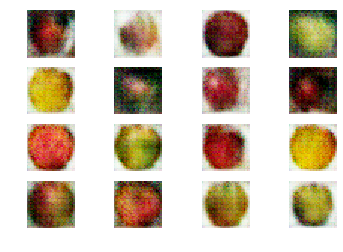

 20%|██        | 40/200 [6:38:15<27:15:47, 613.42s/it]

Epoch: 41/200 | Step: 1/7 [D loss: 0.6820, acc.: 60.16%] [G loss: 1.1888]
Epoch: 41/200 | Step: 2/7 [D loss: 0.6571, acc.: 61.72%] [G loss: 1.2390]
Epoch: 41/200 | Step: 3/7 [D loss: 0.7169, acc.: 51.56%] [G loss: 1.1677]
Epoch: 41/200 | Step: 4/7 [D loss: 0.6084, acc.: 68.75%] [G loss: 1.2608]
Epoch: 41/200 | Step: 5/7 [D loss: 0.6069, acc.: 67.19%] [G loss: 1.3485]
Epoch: 41/200 | Step: 6/7 [D loss: 0.6037, acc.: 73.44%] [G loss: 1.2344]
Epoch: 41/200 | Step: 7/7 [D loss: 0.6455, acc.: 60.16%] [G loss: 1.1759]


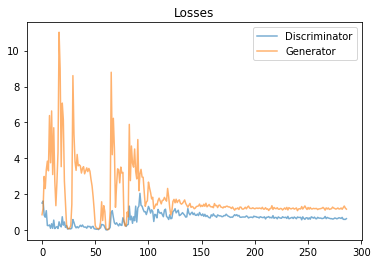

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

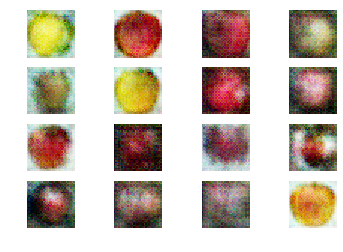

 20%|██        | 41/200 [6:48:28<27:05:10, 613.27s/it]

Epoch: 42/200 | Step: 1/7 [D loss: 0.6291, acc.: 70.31%] [G loss: 1.2437]
Epoch: 42/200 | Step: 2/7 [D loss: 0.5950, acc.: 75.78%] [G loss: 1.2583]
Epoch: 42/200 | Step: 3/7 [D loss: 0.6997, acc.: 52.34%] [G loss: 1.1769]
Epoch: 42/200 | Step: 4/7 [D loss: 0.6028, acc.: 75.00%] [G loss: 1.2719]
Epoch: 42/200 | Step: 5/7 [D loss: 0.5998, acc.: 71.09%] [G loss: 1.2556]
Epoch: 42/200 | Step: 6/7 [D loss: 0.6058, acc.: 74.22%] [G loss: 1.2399]
Epoch: 42/200 | Step: 7/7 [D loss: 0.6043, acc.: 69.53%] [G loss: 1.3388]


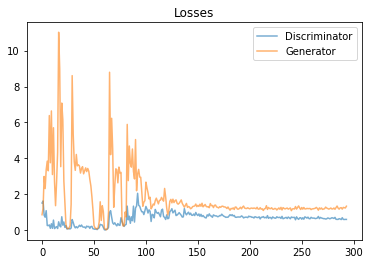

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

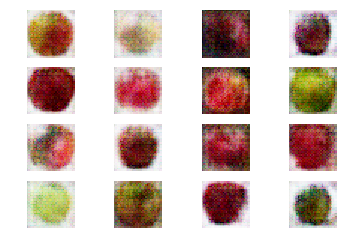

 21%|██        | 42/200 [6:58:41<26:54:56, 613.27s/it]

Epoch: 43/200 | Step: 1/7 [D loss: 0.5852, acc.: 78.12%] [G loss: 1.3103]
Epoch: 43/200 | Step: 2/7 [D loss: 0.6938, acc.: 52.34%] [G loss: 1.2126]
Epoch: 43/200 | Step: 3/7 [D loss: 0.6232, acc.: 71.09%] [G loss: 1.2311]
Epoch: 43/200 | Step: 4/7 [D loss: 0.6424, acc.: 64.84%] [G loss: 1.2240]
Epoch: 43/200 | Step: 5/7 [D loss: 0.6271, acc.: 72.66%] [G loss: 1.2442]
Epoch: 43/200 | Step: 6/7 [D loss: 0.6454, acc.: 63.28%] [G loss: 1.2688]
Epoch: 43/200 | Step: 7/7 [D loss: 0.5842, acc.: 78.91%] [G loss: 1.2643]


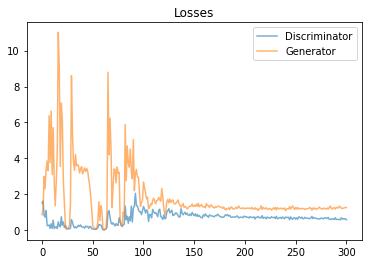

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

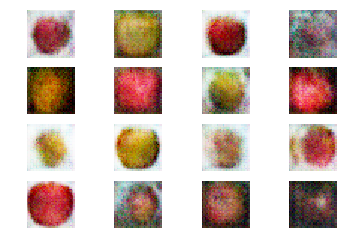

 22%|██▏       | 43/200 [7:09:07<26:54:59, 617.19s/it]

Epoch: 44/200 | Step: 1/7 [D loss: 0.6044, acc.: 68.75%] [G loss: 1.3299]
Epoch: 44/200 | Step: 2/7 [D loss: 0.6384, acc.: 64.84%] [G loss: 1.2180]
Epoch: 44/200 | Step: 3/7 [D loss: 0.5955, acc.: 76.56%] [G loss: 1.2244]
Epoch: 44/200 | Step: 4/7 [D loss: 0.5631, acc.: 82.81%] [G loss: 1.3254]
Epoch: 44/200 | Step: 5/7 [D loss: 0.6343, acc.: 66.41%] [G loss: 1.2005]
Epoch: 44/200 | Step: 6/7 [D loss: 0.5755, acc.: 81.25%] [G loss: 1.2775]
Epoch: 44/200 | Step: 7/7 [D loss: 0.6134, acc.: 67.97%] [G loss: 1.2952]


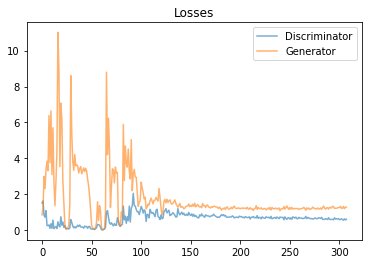

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

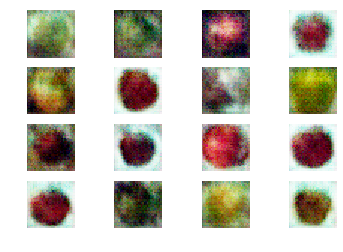

 22%|██▏       | 44/200 [7:19:20<26:40:56, 615.75s/it]

Epoch: 45/200 | Step: 1/7 [D loss: 0.5958, acc.: 74.22%] [G loss: 1.2636]
Epoch: 45/200 | Step: 2/7 [D loss: 0.5770, acc.: 81.25%] [G loss: 1.2700]
Epoch: 45/200 | Step: 3/7 [D loss: 0.5857, acc.: 79.69%] [G loss: 1.2905]
Epoch: 45/200 | Step: 4/7 [D loss: 0.5966, acc.: 75.00%] [G loss: 1.2944]
Epoch: 45/200 | Step: 5/7 [D loss: 0.6530, acc.: 62.50%] [G loss: 1.1903]
Epoch: 45/200 | Step: 6/7 [D loss: 0.5638, acc.: 81.25%] [G loss: 1.3200]
Epoch: 45/200 | Step: 7/7 [D loss: 0.6361, acc.: 65.62%] [G loss: 1.2561]


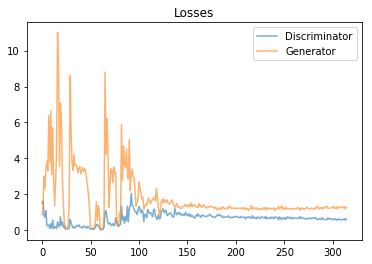

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

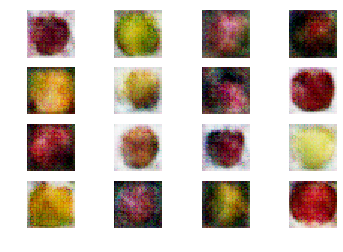

 22%|██▎       | 45/200 [7:29:38<26:32:42, 616.53s/it]

Epoch: 46/200 | Step: 1/7 [D loss: 0.6579, acc.: 62.50%] [G loss: 1.2217]
Epoch: 46/200 | Step: 2/7 [D loss: 0.6496, acc.: 64.84%] [G loss: 1.1893]
Epoch: 46/200 | Step: 3/7 [D loss: 0.5484, acc.: 82.81%] [G loss: 1.3498]
Epoch: 46/200 | Step: 4/7 [D loss: 0.5661, acc.: 80.47%] [G loss: 1.2985]
Epoch: 46/200 | Step: 5/7 [D loss: 0.6546, acc.: 62.50%] [G loss: 1.1751]
Epoch: 46/200 | Step: 6/7 [D loss: 0.5510, acc.: 82.81%] [G loss: 1.3151]
Epoch: 46/200 | Step: 7/7 [D loss: 0.5546, acc.: 77.34%] [G loss: 1.3288]


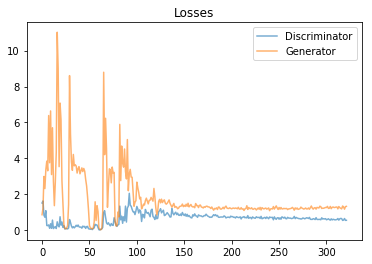

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

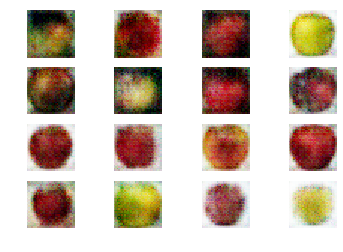

 23%|██▎       | 46/200 [7:39:38<26:09:12, 611.38s/it]

Epoch: 47/200 | Step: 1/7 [D loss: 0.6066, acc.: 74.22%] [G loss: 1.2742]
Epoch: 47/200 | Step: 2/7 [D loss: 0.5615, acc.: 84.38%] [G loss: 1.3293]
Epoch: 47/200 | Step: 3/7 [D loss: 0.5887, acc.: 80.47%] [G loss: 1.2727]
Epoch: 47/200 | Step: 4/7 [D loss: 0.6229, acc.: 70.31%] [G loss: 1.2855]
Epoch: 47/200 | Step: 5/7 [D loss: 0.5680, acc.: 83.59%] [G loss: 1.2549]
Epoch: 47/200 | Step: 6/7 [D loss: 0.5287, acc.: 88.28%] [G loss: 1.3310]
Epoch: 47/200 | Step: 7/7 [D loss: 0.5517, acc.: 87.50%] [G loss: 1.3122]


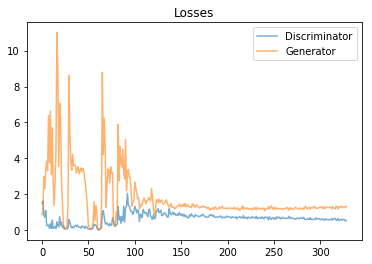

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

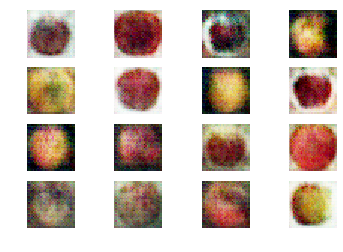

 24%|██▎       | 47/200 [7:49:46<25:57:04, 610.62s/it]

Epoch: 48/200 | Step: 1/7 [D loss: 0.6779, acc.: 57.03%] [G loss: 1.2131]
Epoch: 48/200 | Step: 2/7 [D loss: 0.6317, acc.: 67.19%] [G loss: 1.2619]
Epoch: 48/200 | Step: 3/7 [D loss: 0.5920, acc.: 74.22%] [G loss: 1.2461]
Epoch: 48/200 | Step: 4/7 [D loss: 0.6192, acc.: 70.31%] [G loss: 1.2906]
Epoch: 48/200 | Step: 5/7 [D loss: 0.5770, acc.: 80.47%] [G loss: 1.2883]
Epoch: 48/200 | Step: 6/7 [D loss: 0.6463, acc.: 63.28%] [G loss: 1.2298]
Epoch: 48/200 | Step: 7/7 [D loss: 0.5628, acc.: 84.38%] [G loss: 1.2895]


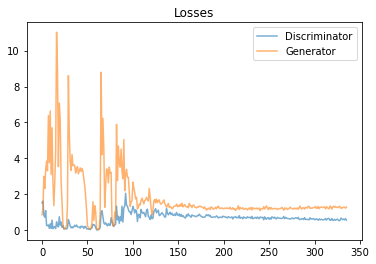

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

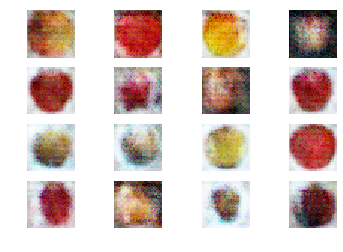

 24%|██▍       | 48/200 [8:00:01<25:49:44, 611.74s/it]

Epoch: 49/200 | Step: 1/7 [D loss: 0.6602, acc.: 60.94%] [G loss: 1.2198]
Epoch: 49/200 | Step: 2/7 [D loss: 0.6002, acc.: 72.66%] [G loss: 1.2626]
Epoch: 49/200 | Step: 3/7 [D loss: 0.5996, acc.: 83.59%] [G loss: 1.2912]
Epoch: 49/200 | Step: 4/7 [D loss: 0.5492, acc.: 85.94%] [G loss: 1.3508]
Epoch: 49/200 | Step: 5/7 [D loss: 0.6690, acc.: 57.03%] [G loss: 1.2591]
Epoch: 49/200 | Step: 6/7 [D loss: 0.5281, acc.: 83.59%] [G loss: 1.3685]
Epoch: 49/200 | Step: 7/7 [D loss: 0.5885, acc.: 76.56%] [G loss: 1.3051]


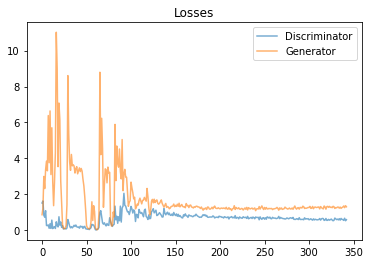

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

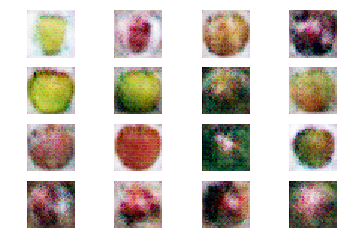

 24%|██▍       | 49/200 [8:10:14<25:40:47, 612.24s/it]

Epoch: 50/200 | Step: 1/7 [D loss: 0.6063, acc.: 73.44%] [G loss: 1.2154]
Epoch: 50/200 | Step: 2/7 [D loss: 0.6055, acc.: 77.34%] [G loss: 1.2063]
Epoch: 50/200 | Step: 3/7 [D loss: 0.5965, acc.: 75.00%] [G loss: 1.2888]
Epoch: 50/200 | Step: 4/7 [D loss: 0.5025, acc.: 91.41%] [G loss: 1.4000]
Epoch: 50/200 | Step: 5/7 [D loss: 0.5211, acc.: 91.41%] [G loss: 1.3223]
Epoch: 50/200 | Step: 6/7 [D loss: 0.5902, acc.: 80.47%] [G loss: 1.2475]
Epoch: 50/200 | Step: 7/7 [D loss: 0.6020, acc.: 71.88%] [G loss: 1.3428]


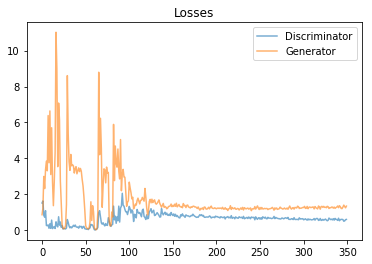

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

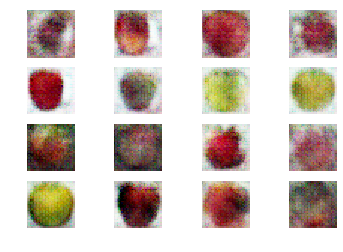

 25%|██▌       | 50/200 [8:20:24<25:28:53, 611.56s/it]

Epoch: 51/200 | Step: 1/7 [D loss: 0.4983, acc.: 94.53%] [G loss: 1.3683]
Epoch: 51/200 | Step: 2/7 [D loss: 0.4838, acc.: 92.19%] [G loss: 1.3252]
Epoch: 51/200 | Step: 3/7 [D loss: 0.5002, acc.: 85.16%] [G loss: 1.2875]
Epoch: 51/200 | Step: 4/7 [D loss: 0.5015, acc.: 92.97%] [G loss: 1.2625]
Epoch: 51/200 | Step: 5/7 [D loss: 0.6335, acc.: 66.41%] [G loss: 1.1998]
Epoch: 51/200 | Step: 6/7 [D loss: 0.5421, acc.: 89.06%] [G loss: 1.1838]
Epoch: 51/200 | Step: 7/7 [D loss: 0.5636, acc.: 79.69%] [G loss: 1.3742]


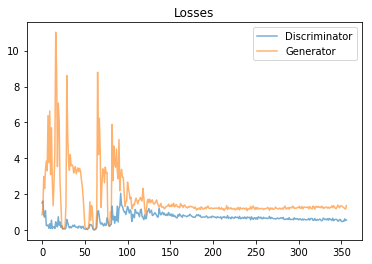

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

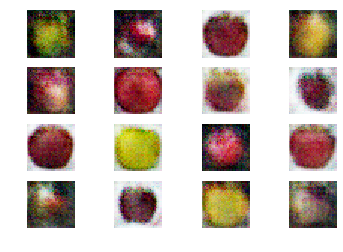

 26%|██▌       | 51/200 [8:30:37<25:19:29, 611.87s/it]

Epoch: 52/200 | Step: 1/7 [D loss: 0.5280, acc.: 85.94%] [G loss: 1.3326]
Epoch: 52/200 | Step: 2/7 [D loss: 0.5725, acc.: 80.47%] [G loss: 1.3294]
Epoch: 52/200 | Step: 3/7 [D loss: 0.5363, acc.: 87.50%] [G loss: 1.3407]
Epoch: 52/200 | Step: 4/7 [D loss: 0.5793, acc.: 74.22%] [G loss: 1.3022]
Epoch: 52/200 | Step: 5/7 [D loss: 0.5340, acc.: 81.25%] [G loss: 1.3854]
Epoch: 52/200 | Step: 6/7 [D loss: 0.5440, acc.: 82.81%] [G loss: 1.3749]
Epoch: 52/200 | Step: 7/7 [D loss: 0.5183, acc.: 89.06%] [G loss: 1.4013]


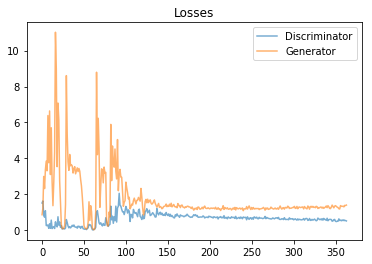

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

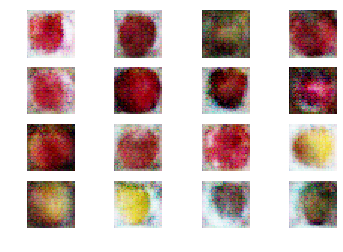

 26%|██▌       | 52/200 [8:40:38<25:01:40, 608.79s/it]

Epoch: 53/200 | Step: 1/7 [D loss: 0.5244, acc.: 85.94%] [G loss: 1.3352]
Epoch: 53/200 | Step: 2/7 [D loss: 0.5023, acc.: 90.62%] [G loss: 1.3853]
Epoch: 53/200 | Step: 3/7 [D loss: 0.6602, acc.: 60.16%] [G loss: 1.2381]
Epoch: 53/200 | Step: 4/7 [D loss: 0.5791, acc.: 78.91%] [G loss: 1.3424]
Epoch: 53/200 | Step: 5/7 [D loss: 0.5028, acc.: 88.28%] [G loss: 1.3707]
Epoch: 53/200 | Step: 6/7 [D loss: 0.5037, acc.: 89.06%] [G loss: 1.4305]
Epoch: 53/200 | Step: 7/7 [D loss: 0.4806, acc.: 96.09%] [G loss: 1.4650]


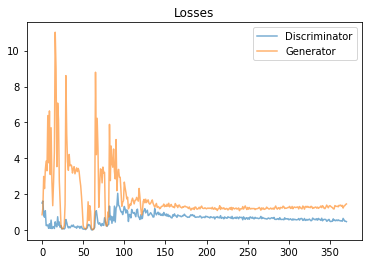

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

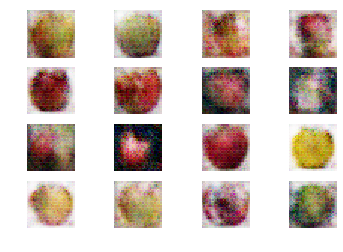

 26%|██▋       | 53/200 [8:50:59<25:00:29, 612.45s/it]

Epoch: 54/200 | Step: 1/7 [D loss: 0.5148, acc.: 87.50%] [G loss: 1.4244]
Epoch: 54/200 | Step: 2/7 [D loss: 0.5423, acc.: 84.38%] [G loss: 1.3223]
Epoch: 54/200 | Step: 3/7 [D loss: 0.5127, acc.: 89.06%] [G loss: 1.3904]
Epoch: 54/200 | Step: 4/7 [D loss: 0.6096, acc.: 69.53%] [G loss: 1.2729]
Epoch: 54/200 | Step: 5/7 [D loss: 0.4554, acc.: 95.31%] [G loss: 1.4749]
Epoch: 54/200 | Step: 6/7 [D loss: 0.5089, acc.: 89.84%] [G loss: 1.4467]
Epoch: 54/200 | Step: 7/7 [D loss: 0.5527, acc.: 79.69%] [G loss: 1.4052]


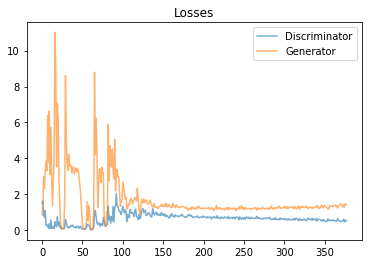

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

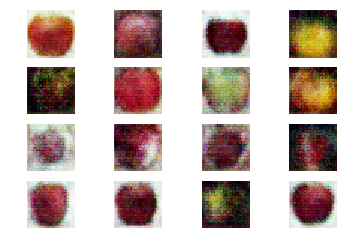

 27%|██▋       | 54/200 [9:00:25<24:16:07, 598.40s/it]

Epoch: 55/200 | Step: 1/7 [D loss: 0.5733, acc.: 80.47%] [G loss: 1.2925]
Epoch: 55/200 | Step: 2/7 [D loss: 0.5012, acc.: 92.19%] [G loss: 1.4304]
Epoch: 55/200 | Step: 3/7 [D loss: 0.5216, acc.: 87.50%] [G loss: 1.4096]
Epoch: 55/200 | Step: 4/7 [D loss: 0.4859, acc.: 96.09%] [G loss: 1.4265]
Epoch: 55/200 | Step: 5/7 [D loss: 0.5237, acc.: 88.28%] [G loss: 1.4299]
Epoch: 55/200 | Step: 6/7 [D loss: 0.5186, acc.: 89.06%] [G loss: 1.3939]
Epoch: 55/200 | Step: 7/7 [D loss: 0.4876, acc.: 87.50%] [G loss: 1.4496]


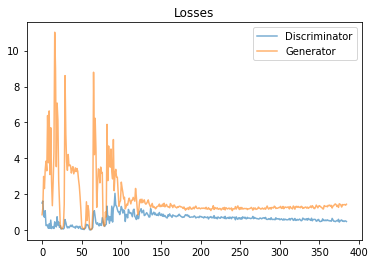

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

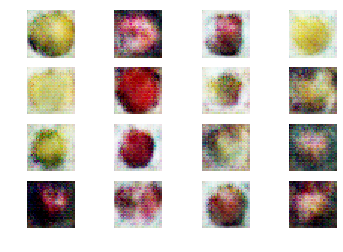

 28%|██▊       | 55/200 [9:09:50<23:41:51, 588.35s/it]

Epoch: 56/200 | Step: 1/7 [D loss: 0.5057, acc.: 93.75%] [G loss: 1.4304]
Epoch: 56/200 | Step: 2/7 [D loss: 0.5834, acc.: 78.91%] [G loss: 1.2914]
Epoch: 56/200 | Step: 3/7 [D loss: 0.5396, acc.: 85.94%] [G loss: 1.4396]
Epoch: 56/200 | Step: 4/7 [D loss: 0.5043, acc.: 92.19%] [G loss: 1.4365]
Epoch: 56/200 | Step: 5/7 [D loss: 0.5789, acc.: 78.91%] [G loss: 1.3860]
Epoch: 56/200 | Step: 6/7 [D loss: 0.4773, acc.: 92.97%] [G loss: 1.4771]
Epoch: 56/200 | Step: 7/7 [D loss: 0.5257, acc.: 88.28%] [G loss: 1.4261]


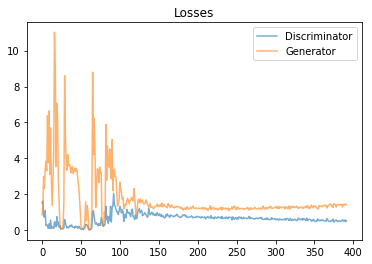

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

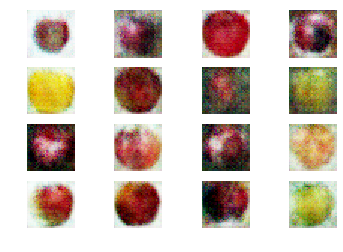

 28%|██▊       | 56/200 [9:19:19<23:18:14, 582.60s/it]

Epoch: 57/200 | Step: 1/7 [D loss: 0.5417, acc.: 88.28%] [G loss: 1.2630]
Epoch: 57/200 | Step: 2/7 [D loss: 0.4466, acc.: 92.19%] [G loss: 1.4434]
Epoch: 57/200 | Step: 3/7 [D loss: 0.5698, acc.: 75.78%] [G loss: 1.3579]
Epoch: 57/200 | Step: 4/7 [D loss: 0.6040, acc.: 76.56%] [G loss: 1.3770]
Epoch: 57/200 | Step: 5/7 [D loss: 0.4531, acc.: 96.88%] [G loss: 1.5174]
Epoch: 57/200 | Step: 6/7 [D loss: 0.4912, acc.: 89.84%] [G loss: 1.5184]
Epoch: 57/200 | Step: 7/7 [D loss: 0.4970, acc.: 86.72%] [G loss: 1.4452]


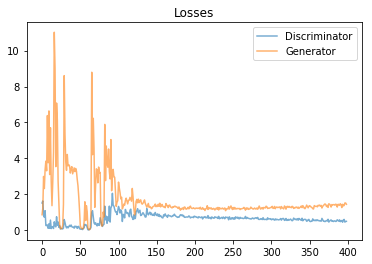

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

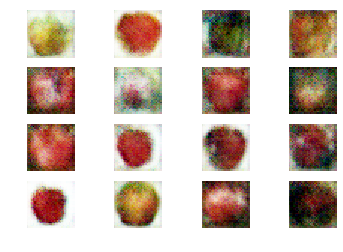

 28%|██▊       | 57/200 [9:29:08<23:13:20, 584.62s/it]

Epoch: 58/200 | Step: 1/7 [D loss: 0.4402, acc.: 96.88%] [G loss: 1.4319]
Epoch: 58/200 | Step: 2/7 [D loss: 0.4822, acc.: 89.84%] [G loss: 1.4365]
Epoch: 58/200 | Step: 3/7 [D loss: 0.5089, acc.: 89.06%] [G loss: 1.4397]
Epoch: 58/200 | Step: 4/7 [D loss: 0.4761, acc.: 92.97%] [G loss: 1.5104]
Epoch: 58/200 | Step: 5/7 [D loss: 0.4320, acc.: 99.22%] [G loss: 1.5110]
Epoch: 58/200 | Step: 6/7 [D loss: 0.4432, acc.: 97.66%] [G loss: 1.5516]
Epoch: 58/200 | Step: 7/7 [D loss: 0.5373, acc.: 80.47%] [G loss: 1.4566]


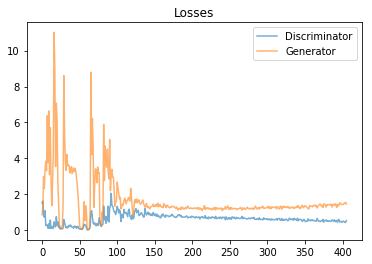

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

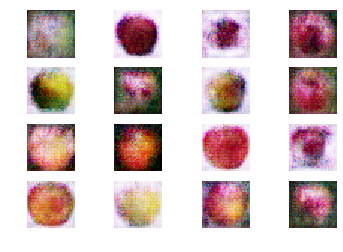

 29%|██▉       | 58/200 [9:39:20<23:22:55, 592.79s/it]

Epoch: 59/200 | Step: 1/7 [D loss: 0.3892, acc.: 95.31%] [G loss: 1.5054]
Epoch: 59/200 | Step: 2/7 [D loss: 0.4934, acc.: 89.06%] [G loss: 1.4781]
Epoch: 59/200 | Step: 3/7 [D loss: 0.5136, acc.: 86.72%] [G loss: 1.4654]
Epoch: 59/200 | Step: 4/7 [D loss: 0.4889, acc.: 92.97%] [G loss: 1.4314]
Epoch: 59/200 | Step: 5/7 [D loss: 0.4624, acc.: 96.09%] [G loss: 1.4807]
Epoch: 59/200 | Step: 6/7 [D loss: 0.4884, acc.: 91.41%] [G loss: 1.4782]
Epoch: 59/200 | Step: 7/7 [D loss: 0.4298, acc.: 94.53%] [G loss: 1.4593]


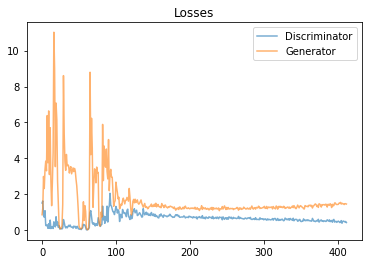

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

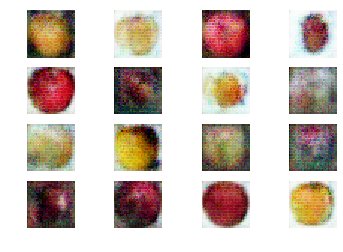

 30%|██▉       | 59/200 [9:49:07<23:08:55, 591.03s/it]

Epoch: 60/200 | Step: 1/7 [D loss: 0.5070, acc.: 88.28%] [G loss: 1.4414]
Epoch: 60/200 | Step: 2/7 [D loss: 0.4851, acc.: 91.41%] [G loss: 1.5060]
Epoch: 60/200 | Step: 3/7 [D loss: 0.4024, acc.: 99.22%] [G loss: 1.5762]
Epoch: 60/200 | Step: 4/7 [D loss: 0.4907, acc.: 92.19%] [G loss: 1.5114]
Epoch: 60/200 | Step: 5/7 [D loss: 0.4286, acc.: 96.88%] [G loss: 1.5971]
Epoch: 60/200 | Step: 6/7 [D loss: 0.5021, acc.: 92.19%] [G loss: 1.4901]
Epoch: 60/200 | Step: 7/7 [D loss: 0.4598, acc.: 92.97%] [G loss: 1.4927]


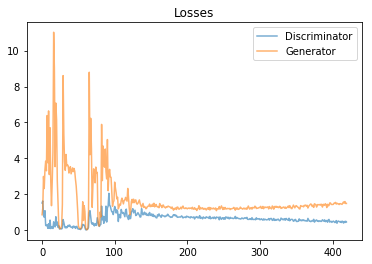

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

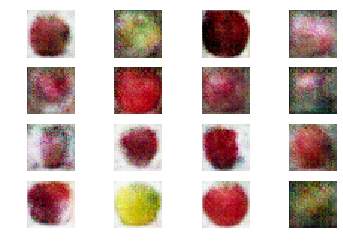

 30%|███       | 60/200 [9:59:30<23:21:13, 600.53s/it]

Epoch: 61/200 | Step: 1/7 [D loss: 0.4641, acc.: 92.97%] [G loss: 1.5552]
Epoch: 61/200 | Step: 2/7 [D loss: 0.4885, acc.: 91.41%] [G loss: 1.4956]
Epoch: 61/200 | Step: 3/7 [D loss: 0.4706, acc.: 94.53%] [G loss: 1.5168]
Epoch: 61/200 | Step: 4/7 [D loss: 0.4167, acc.: 96.09%] [G loss: 1.5682]
Epoch: 61/200 | Step: 5/7 [D loss: 0.4302, acc.: 98.44%] [G loss: 1.5563]
Epoch: 61/200 | Step: 6/7 [D loss: 0.4798, acc.: 92.97%] [G loss: 1.4639]
Epoch: 61/200 | Step: 7/7 [D loss: 0.4614, acc.: 93.75%] [G loss: 1.5463]


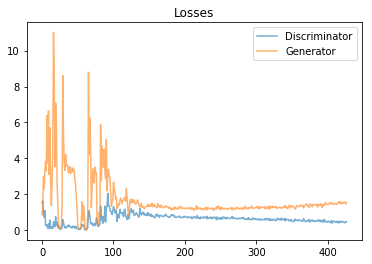

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

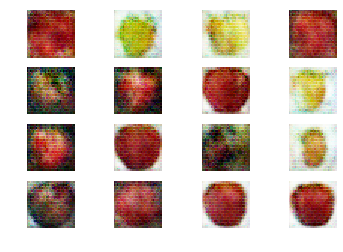

 30%|███       | 61/200 [10:09:53<23:27:04, 607.37s/it]

Epoch: 62/200 | Step: 1/7 [D loss: 0.4006, acc.: 97.66%] [G loss: 1.5659]
Epoch: 62/200 | Step: 2/7 [D loss: 0.4557, acc.: 95.31%] [G loss: 1.5371]
Epoch: 62/200 | Step: 3/7 [D loss: 0.3972, acc.: 99.22%] [G loss: 1.6416]
Epoch: 62/200 | Step: 4/7 [D loss: 0.4729, acc.: 92.97%] [G loss: 1.5066]
Epoch: 62/200 | Step: 5/7 [D loss: 0.4394, acc.: 96.09%] [G loss: 1.6000]
Epoch: 62/200 | Step: 6/7 [D loss: 0.5232, acc.: 86.72%] [G loss: 1.4225]
Epoch: 62/200 | Step: 7/7 [D loss: 0.4783, acc.: 94.53%] [G loss: 1.4635]


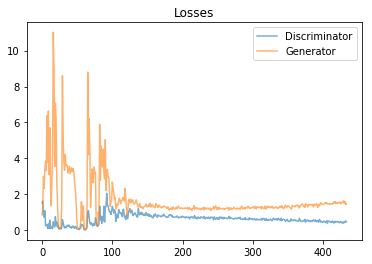

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

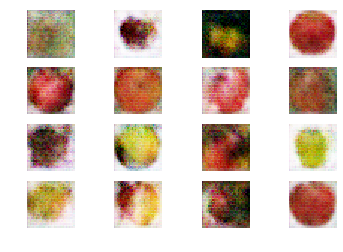

 31%|███       | 62/200 [10:20:22<23:31:38, 613.76s/it]

Epoch: 63/200 | Step: 1/7 [D loss: 0.4368, acc.: 92.97%] [G loss: 1.5847]
Epoch: 63/200 | Step: 2/7 [D loss: 0.4979, acc.: 87.50%] [G loss: 1.4709]
Epoch: 63/200 | Step: 3/7 [D loss: 0.3839, acc.: 99.22%] [G loss: 1.5685]
Epoch: 63/200 | Step: 4/7 [D loss: 0.3666, acc.: 96.88%] [G loss: 1.6777]
Epoch: 63/200 | Step: 5/7 [D loss: 0.4849, acc.: 89.84%] [G loss: 1.5054]
Epoch: 63/200 | Step: 6/7 [D loss: 0.4740, acc.: 91.41%] [G loss: 1.5223]
Epoch: 63/200 | Step: 7/7 [D loss: 0.4057, acc.: 96.09%] [G loss: 1.6066]


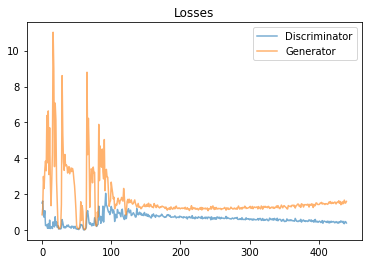

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

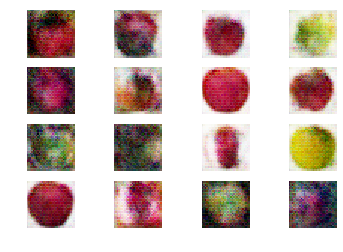

 32%|███▏      | 63/200 [10:30:32<23:19:00, 612.71s/it]

Epoch: 64/200 | Step: 1/7 [D loss: 0.5915, acc.: 74.22%] [G loss: 1.4746]
Epoch: 64/200 | Step: 2/7 [D loss: 0.5900, acc.: 71.09%] [G loss: 1.3946]
Epoch: 64/200 | Step: 3/7 [D loss: 0.3918, acc.: 93.75%] [G loss: 1.6380]
Epoch: 64/200 | Step: 4/7 [D loss: 0.4693, acc.: 91.41%] [G loss: 1.5545]
Epoch: 64/200 | Step: 5/7 [D loss: 0.4677, acc.: 94.53%] [G loss: 1.5524]
Epoch: 64/200 | Step: 6/7 [D loss: 0.4306, acc.: 98.44%] [G loss: 1.5654]
Epoch: 64/200 | Step: 7/7 [D loss: 0.4044, acc.: 96.88%] [G loss: 1.6217]


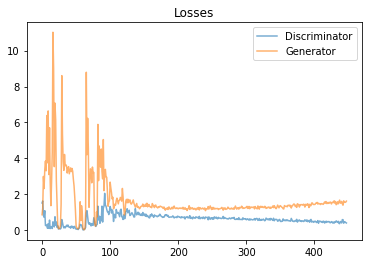

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

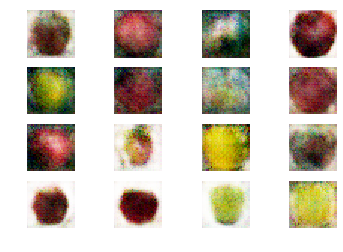

 32%|███▏      | 64/200 [10:40:48<23:11:07, 613.73s/it]

Epoch: 65/200 | Step: 1/7 [D loss: 0.3913, acc.: 98.44%] [G loss: 1.6215]
Epoch: 65/200 | Step: 2/7 [D loss: 0.4007, acc.: 96.09%] [G loss: 1.6273]
Epoch: 65/200 | Step: 3/7 [D loss: 0.4386, acc.: 96.09%] [G loss: 1.5744]
Epoch: 65/200 | Step: 4/7 [D loss: 0.3771, acc.: 99.22%] [G loss: 1.7171]
Epoch: 65/200 | Step: 5/7 [D loss: 0.4174, acc.: 96.88%] [G loss: 1.6943]
Epoch: 65/200 | Step: 6/7 [D loss: 0.4144, acc.: 94.53%] [G loss: 1.5689]
Epoch: 65/200 | Step: 7/7 [D loss: 0.4272, acc.: 98.44%] [G loss: 1.5605]


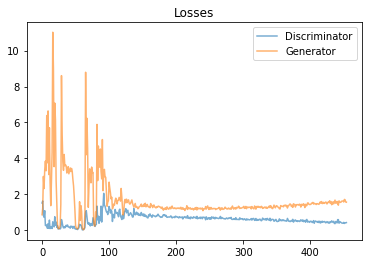

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

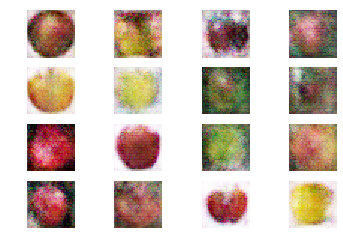

 32%|███▎      | 65/200 [10:51:09<23:05:23, 615.73s/it]

Epoch: 66/200 | Step: 1/7 [D loss: 0.4881, acc.: 89.84%] [G loss: 1.5062]
Epoch: 66/200 | Step: 2/7 [D loss: 0.3786, acc.: 98.44%] [G loss: 1.5784]
Epoch: 66/200 | Step: 3/7 [D loss: 0.3584, acc.: 97.66%] [G loss: 1.5940]
Epoch: 66/200 | Step: 4/7 [D loss: 0.4381, acc.: 95.31%] [G loss: 1.5843]
Epoch: 66/200 | Step: 5/7 [D loss: 0.3916, acc.: 97.66%] [G loss: 1.6530]
Epoch: 66/200 | Step: 6/7 [D loss: 0.4698, acc.: 92.19%] [G loss: 1.5344]
Epoch: 66/200 | Step: 7/7 [D loss: 0.4503, acc.: 95.31%] [G loss: 1.5655]


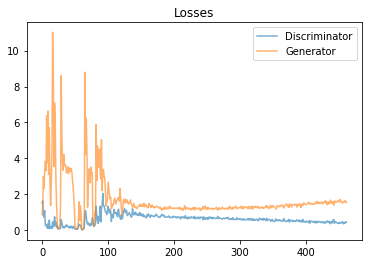

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

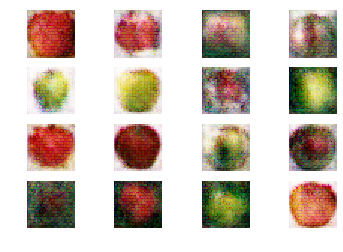

 33%|███▎      | 66/200 [11:00:59<22:37:55, 608.02s/it]

Epoch: 67/200 | Step: 1/7 [D loss: 0.3973, acc.: 98.44%] [G loss: 1.6457]
Epoch: 67/200 | Step: 2/7 [D loss: 0.4073, acc.: 99.22%] [G loss: 1.6012]
Epoch: 67/200 | Step: 3/7 [D loss: 0.4046, acc.: 96.09%] [G loss: 1.5588]
Epoch: 67/200 | Step: 4/7 [D loss: 0.4189, acc.: 97.66%] [G loss: 1.5549]
Epoch: 67/200 | Step: 5/7 [D loss: 0.4103, acc.: 97.66%] [G loss: 1.6099]
Epoch: 67/200 | Step: 6/7 [D loss: 0.4754, acc.: 94.53%] [G loss: 1.6897]
Epoch: 67/200 | Step: 7/7 [D loss: 0.4783, acc.: 92.19%] [G loss: 1.5063]


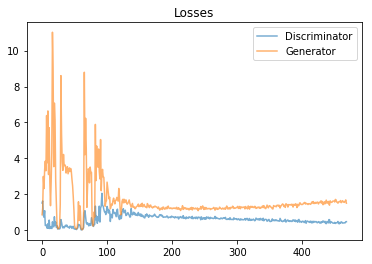

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

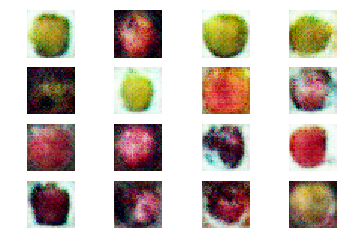

 34%|███▎      | 67/200 [11:10:17<21:54:56, 593.21s/it]

Epoch: 68/200 | Step: 1/7 [D loss: 0.3843, acc.: 98.44%] [G loss: 1.6205]
Epoch: 68/200 | Step: 2/7 [D loss: 0.3426, acc.: 100.00%] [G loss: 1.7087]
Epoch: 68/200 | Step: 3/7 [D loss: 0.4595, acc.: 90.62%] [G loss: 1.5895]
Epoch: 68/200 | Step: 4/7 [D loss: 0.4121, acc.: 96.09%] [G loss: 1.5795]
Epoch: 68/200 | Step: 5/7 [D loss: 0.3943, acc.: 97.66%] [G loss: 1.6933]
Epoch: 68/200 | Step: 6/7 [D loss: 0.3852, acc.: 96.09%] [G loss: 1.6574]
Epoch: 68/200 | Step: 7/7 [D loss: 0.5125, acc.: 87.50%] [G loss: 1.5178]


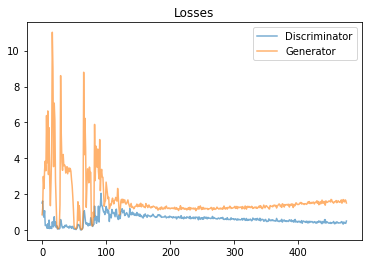

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

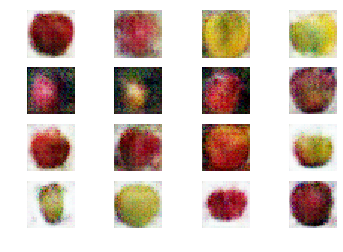

 34%|███▍      | 68/200 [11:19:54<21:33:51, 588.12s/it]

Epoch: 69/200 | Step: 1/7 [D loss: 0.4043, acc.: 96.88%] [G loss: 1.6877]
Epoch: 69/200 | Step: 2/7 [D loss: 0.4415, acc.: 96.09%] [G loss: 1.5649]
Epoch: 69/200 | Step: 3/7 [D loss: 0.3861, acc.: 100.00%] [G loss: 1.6635]
Epoch: 69/200 | Step: 4/7 [D loss: 0.3469, acc.: 99.22%] [G loss: 1.7335]
Epoch: 69/200 | Step: 5/7 [D loss: 0.3939, acc.: 98.44%] [G loss: 1.6412]
Epoch: 69/200 | Step: 6/7 [D loss: 0.4556, acc.: 96.09%] [G loss: 1.4908]
Epoch: 69/200 | Step: 7/7 [D loss: 0.4376, acc.: 92.97%] [G loss: 1.6411]


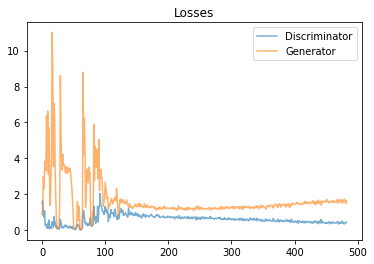

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

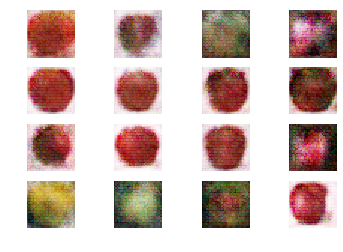

 34%|███▍      | 69/200 [11:29:09<21:02:22, 578.19s/it]

Epoch: 70/200 | Step: 1/7 [D loss: 0.2987, acc.: 100.00%] [G loss: 1.8513]
Epoch: 70/200 | Step: 2/7 [D loss: 0.3468, acc.: 100.00%] [G loss: 1.8016]
Epoch: 70/200 | Step: 3/7 [D loss: 0.3861, acc.: 99.22%] [G loss: 1.6784]
Epoch: 70/200 | Step: 4/7 [D loss: 0.4328, acc.: 94.53%] [G loss: 1.5963]
Epoch: 70/200 | Step: 5/7 [D loss: 0.4501, acc.: 93.75%] [G loss: 1.5999]
Epoch: 70/200 | Step: 6/7 [D loss: 0.3115, acc.: 100.00%] [G loss: 1.8101]
Epoch: 70/200 | Step: 7/7 [D loss: 0.3861, acc.: 99.22%] [G loss: 1.6638]


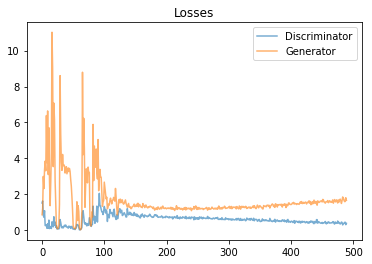

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

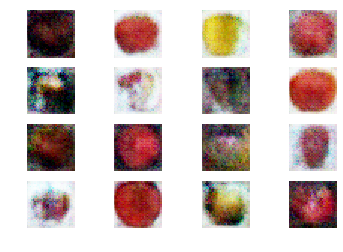

 35%|███▌      | 70/200 [11:38:20<20:35:28, 570.22s/it]

Epoch: 71/200 | Step: 1/7 [D loss: 0.4156, acc.: 92.97%] [G loss: 1.6694]
Epoch: 71/200 | Step: 2/7 [D loss: 0.3366, acc.: 100.00%] [G loss: 1.7467]
Epoch: 71/200 | Step: 3/7 [D loss: 0.3861, acc.: 97.66%] [G loss: 1.7150]
Epoch: 71/200 | Step: 4/7 [D loss: 0.3929, acc.: 97.66%] [G loss: 1.6611]
Epoch: 71/200 | Step: 5/7 [D loss: 0.3337, acc.: 97.66%] [G loss: 1.7139]
Epoch: 71/200 | Step: 6/7 [D loss: 0.3733, acc.: 97.66%] [G loss: 1.7690]
Epoch: 71/200 | Step: 7/7 [D loss: 0.3397, acc.: 99.22%] [G loss: 1.7092]


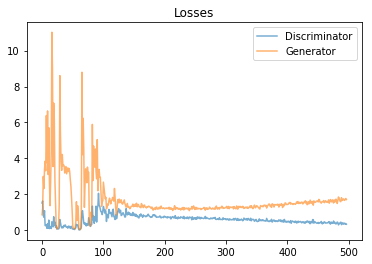

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

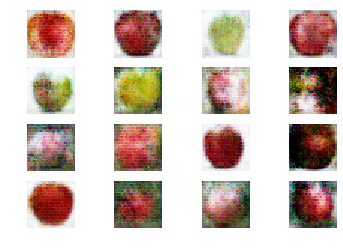

 36%|███▌      | 71/200 [11:47:34<20:15:35, 565.40s/it]

Epoch: 72/200 | Step: 1/7 [D loss: 0.3868, acc.: 100.00%] [G loss: 1.7420]


In [0]:
warnings.filterwarnings("ignore")
from tqdm import tqdm

d_loss_list = []
g_loss_list = []

for epoch in tqdm(range(EPOCHS)):
    epoch += 1 #start from 1
    # So, need to append d_loss, g_loss, and step to a dataframe with epoch as 
    
    for step in range(steps_per_epoch):
        step += 1 #start from 1

        # ---------------------
        #  Train Discriminator
        # ---------------------

        # Select a random half of images
        idx = np.random.randint(0, images.shape[0], BATCH_SIZE)
        imgs = images[idx]

        # Sample noise and generate a batch of new images
        noise = np.random.normal(0, 1, (BATCH_SIZE, NOISE_SIZE))
        gen_imgs = model_generator.predict(noise)


        # Train the discriminator (real classified as ones and generated as zeros)
        d_loss_real = model_discriminator.train_on_batch(imgs, valid)
        d_loss_fake = model_discriminator.train_on_batch(gen_imgs, fake)
        d_loss = 0.5 * np.add(d_loss_real, d_loss_fake)

        # ---------------------
        #  Train GAN
        # ---------------------

        # Train the generator (wants discriminator to mistake images as real)
        g_loss = gan.train_on_batch(noise, valid)

        # Plot the progress
        print ("Epoch: {}/{} | Step: {}/{} [D loss: {:.4f}, acc.: {:.2f}%] [G loss: {:.4f}]".format(
                    epoch, EPOCHS, step, steps_per_epoch, d_loss[0], 100*d_loss[1], g_loss
                ))

        # Append d_loss, g_loss, and step to a dataframe
        #step_df = df.append({'d_loss' : d_loss[0], 'g_loss' : g_loss}, ignore_index=True)

        d_loss_zero = d_loss[0]

        d_loss_list.append(d_loss_zero)
        g_loss_list.append(g_loss)


  # Plot Loss
    summarize_epoch(d_loss_list,g_loss_list)

    # Plot images
    gen_imgs = model_generator.predict(noise)

    fig, axs = plt.subplots(r, c)
    cnt = 0
    for i in range(r):
        for j in range(c):
            axs[i,j].imshow(gen_imgs[cnt, :, :, :])
            axs[i,j].axis('off')
            cnt += 1
    plt.show()
    plt.close()
  
    if epoch % 10 == 0:
        model_generator.save("g{}.h5".format(epoch))
